In [1]:
# ML
import torch
import torch.nn as nn
from sklearn import datasets

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Circle, Wedge, Polygon
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv # Interactive 3D plots

# Math
import math
from math import cos, sin
import numpy as np
import random

#clustering 
from sklearn.cluster import AgglomerativeClustering

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.style.use('seaborn')

# Set seed for reproducibility
random.seed(2019)
np.random.seed(2019)
torch.manual_seed(2019)
torch.cuda.manual_seed(12)

torch.backends.cudnn.deterministic=True

## 1 Neural Network

In [3]:
def train(x, y, model, crit, optimizer):
    
    converge_order = []
    idx = 0
    epochs = 1000
    print_iter = 200
    nrows = int(epochs / print_iter) + 1
    
    o = []
    
    def hook(module, input, output):
        o.append(output)
        
    model[1].register_forward_hook(hook)

    
    # Create a subplot
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(14, 20))

    for epoch in range(epochs):
        y_pred = model(x)
        loss = crit(y_pred,y)
        optimizer.zero_grad()
        
        loss.backward()  # back pass
        param_group = optimizer.param_groups[0]['params'][0]
        
        #number of hidden units
        h_size = len(param_group)

        #get the current x
        data = param_group.data.clone()

        optimizer.step() # update params

        diff = torch.sub(data,param_group.data)
        
        for ind in range(len(diff)):
            if diff[ind][0] < 0.0001 and diff[ind][1] < 0.0001:
                if ind not in [x for x,y in converge_order]:
                    if epoch != 0:
                        print("hidden unit " + str(ind) + " converged at epoch " + str(epoch))
                    converge_order.append((ind,epoch))
                
        

        if (epoch % print_iter) == 0 or (epoch == (epochs - 1)):
            """
            ax[idx][0].figure(1, figsize=(5,5))
            ax[idx][1].figure(1, figsize=(5,5))
            ax[idx][2].figure(1, figsize=(5,5))
            ax[idx][3].figure(1, figsize=(5,5))
            """
            
            plot_regions(x,y,model, ax[idx][0], "Epoch " + str(epoch))        
            # Print out model weights
            model_weights_plot(model, ax[idx][1], "Model Weights")
            # Print out the linear output values
            output_plot(model, o, ax[idx][2], "Linear Output Values")
            combined_plot(model, o, ax[idx][3], "|Ouput Value * Model Weight|")
            idx = idx + 1
        o = []

    plt.show()
    
    print("Convergence order of units",converge_order)
    return loss

In [4]:
def model_weights_plot(model, s_plt, title):
    weights1 = np.array(model[0].weight.tolist())
    weights2 = np.array(model[2].weight.tolist())[0]
    s_plt.title.set_text(title)
    s_plt.bar(list(range(len(weights2))), weights2)
    s_plt.plot()
    
def output_plot(model, o, s_plt, title):
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    s_plt.title.set_text(title)
    s_plt.bar(list(range(len(t))), t)
    
def combined_plot(model, o, s_plt, title):
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    weights2 = np.array(model[2].weight.tolist())[0]
    c_plot = np.abs(weights2*t)
    #plt.title("|Ouput Value * Model Weight|")
    s_plt.title.set_text(title)
    s_plt.bar(list(range(len(c_plot))), c_plot)

    plt.tight_layout()
    #s_plt.plot()
    
def plot_fin_model(model, x, y):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

    
    preds, output = pred(model, x)
    output = np.array(output[0].tolist())

    x = np.array(x.tolist())
    y = np.array(y.tolist())

    # Get average output for each class
    output0 = np.array([output[i] for i, y_i in enumerate(y) if y_i == 0])
    output1 = np.array([output[i] for i, y_i in enumerate(y) if y_i == 1])
    
    # Plot final output
    plot_regions(x, y, model, ax[0][0], "Output 0")        
    # Print out model weights
    model_weights_plot(model, ax[0][1], "Model Weights")
    # Print out the linear output values
    output_plot(model, [output0], ax[0][2], "Linear Output Values")
    combined_plot(model, [output0], ax[0][3], "|Ouput Value * Model Weight|")

    # Plot final output
    plot_regions(x, y, model, ax[1][0], "Output 1")        
    # Print out model weights
    model_weights_plot(model, ax[1][1], "Model Weights")
    # Print out the linear output values
    output_plot(model, [output1], ax[1][2], "Linear Output Values")
    combined_plot(model, [output1], ax[1][3], "|Ouput Value * Model Weight|")
    
def plot_weights(model):
    layer_1_w = np.array(model[0].weight.tolist())
    layer_1_b = np.array(model[0].bias.tolist())
    layer_1_b = layer_1_b.reshape(-1, 1)
    
    weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
    fig = plt.figure(figsize = (6, 6))
    ax = Axes3D(fig, elev = -150, azim = 130)
    ax.scatter(weights[:,0], weights[:,1], weights[:,2])
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Y')
    plt.show()

In [5]:
def pred(model, x):
    o = []
        
    def hook(module, input, output):
        o.append(output)
        
    model[1].register_forward_hook(hook)
    
    #return values and outputs after first hidden layer
    return model(torch.FloatTensor(x)).tolist(), o

# MODIFIYING NUM CHANGES QUALITY & RUN-TIME DRAMATICALLY
def rand_points():
    num = 50
    x_points = np.linspace(-5.5,5.5,num)
    y_points = np.linspace(-5.5,5.5,num)
    points = [[x,y] for x in x_points for y in y_points]
    return points

def train_vals(x):
    return ([z[0] for z in x.tolist()],[z[1] for z in x.tolist()])

def plot_regions(x,y,model, s_plt, title, idx=-1):
    x_train,y_train = train_vals(x)
    points = rand_points()
    x_map = [x[0] for x in points]
    y_map = [x[1] for x in points]
    val = pred(model,points)
    preds = val[0]
    out = val[1]    
    
    
    #get colors
    c1 = ['g','b']
    c2 = ['#E2E79F','#FF90FF']
    
    #c1 = ['r', 'b']
    #c2 = ['r', 'b']
    
    train_map = [c1[int(x[0])] for x in y.tolist()]
    cmap = [c2[0] if x[0] < 0.5 else c2[1] for x in preds]
    #plot points
    #print(len(x_map))
    s_plt.title.set_text(title)
    s_plt.scatter(x_map, y_map, color=cmap, alpha=0.22,  marker='o', s=10)
    s_plt.scatter(x_train, y_train, color=train_map, alpha=0.7, marker='o', s=10)
    
    #s_plt.xlabel('X1')
    #s_plt.ylabel('X2')
    #show classification regions
    if idx == -1:
        s_plt.plot()
    else:
        plt.subplot(5,2,idx)
        
    return out

## 2 Synthetic data set generator

### 2.1 Generate circles and disks

In [6]:
def gen_circle(n, x, y, radius, disk_start=0, circ_start=0, circ_end=1, noise=False):
    """
    Generates points in within a specific disk.
    
    Args:
        - n: Number of points to generate
        - x: X-axis center of circle
        - y: Y-axis center of circle
        - radius:     Radius of circle
        - disk_start: [0, 1] where to start center of circle
        - circ_start: [0, 1] Start place of circle (Defaults 0 == 3PM).
        - circ_end:   [0, 1] End place of circle (Defaults 1 == 3PM, wraps around counter clockwise).
        - noise:      Add standard normal noise to data points
    """
    data = []
    for i in range(n):
        arc = random.uniform(circ_start, circ_end) * 2 * math.pi
        r = radius * np.sqrt(random.uniform(disk_start, 1))
        
        p_x = r * np.cos(arc) + x
        p_y = r * np.sin(arc) + y
        
        if noise:
            p_x += np.random.normal(0,1)
            p_y += np.random.normal(0,1)
            
        data.append([p_x, p_y])
    return data

### 2.2 Visualize two datasets

In [ ]:
def plot(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    figure(num=None, figsize=(6, 6), dpi=120, facecolor='w', edgecolor='k')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, aspect='equal')


    """
    axis = { 'xmin' : -10, 
             'xmax' : 10, 
             'ymin' : -10, 
             'ymax' : 10 }

    #ax2.add_artist(Circle((x, y), r, color=(1,0,0,.7)))
    plt.axis(**axis)"""
    plt.scatter(data1[:, 0], data1[:, 1])
    plt.scatter(data2[:, 0], data2[:, 1])
    plt.show()

In [ ]:
def get_acc(model, x, y):
    y = np.array(y.tolist())
    predictions = np.array([1 if (p[0] >= 0.5) else 0 for p in model(torch.FloatTensor(x)).tolist()]).reshape(-1, 1)
    return np.sum(predictions == y)/len(y)

## 3 Neural net visualization

<Figure size 720x720 with 0 Axes>

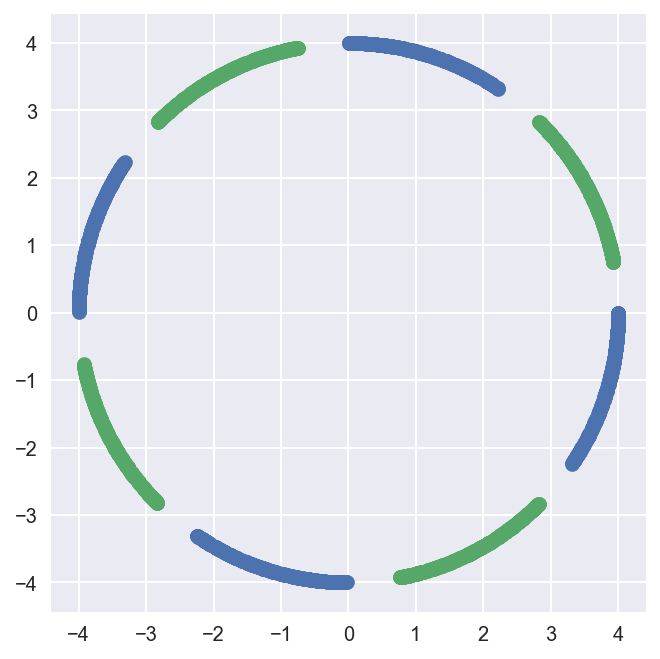

2800
2800


In [ ]:
seq = np.linspace(0,1,9)
pairs = [(seq[i] + .03, seq[i+1]) for i in range(len(seq[:-1]))]

n = 250
r = 4
x = 0
y = 0

data = []
d1 = []
d2 = []
l1 = []
l2 = []

labels = []
for i, pair in enumerate(pairs):
    datum = gen_circle(350, x, y, r, disk_start = 1, circ_start = pair[0], circ_end = pair[1])
    if (i % 2):
        d1 += datum
    else:
        d2 += datum

l1 = [[1]]*len(d1)
l2 = [[0]]*len(d2)


x = torch.FloatTensor(d1 + d2)
y = l1 + l2
y = torch.FloatTensor(y)
plot(d1, d2)
print(len(x))
print(len(y))

In [ ]:
def train_run_model(x, y, sgd=True, H=8):
    d = 2

    model = nn.Sequential(nn.Linear(d,H), nn.ReLU(), nn.Linear(H,1), nn.Sigmoid())
    crit = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    
    if sgd:
        optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
    
    loss = train(x,y,model,crit,optimizer)
    acc = get_acc(model, x, y)

    print("The loss is " + str(loss.tolist()))
    print("Accuracy: %.5f" % (get_acc(model, x, y)))

    return model

## SGD Optimizer

### 3.1 SGD, ARCS = 8,  H = 8

hidden unit 0 converged at epoch 1
hidden unit 2 converged at epoch 1
hidden unit 4 converged at epoch 1
hidden unit 0 converged at epoch 2
hidden unit 2 converged at epoch 2
hidden unit 4 converged at epoch 2
hidden unit 0 converged at epoch 3
hidden unit 2 converged at epoch 3
hidden unit 4 converged at epoch 3
hidden unit 0 converged at epoch 4
hidden unit 2 converged at epoch 4
hidden unit 4 converged at epoch 4
hidden unit 0 converged at epoch 5
hidden unit 2 converged at epoch 5
hidden unit 4 converged at epoch 5
hidden unit 0 converged at epoch 6
hidden unit 2 converged at epoch 6
hidden unit 4 converged at epoch 6
hidden unit 0 converged at epoch 7
hidden unit 2 converged at epoch 7
hidden unit 4 converged at epoch 7
hidden unit 0 converged at epoch 8
hidden unit 2 converged at epoch 8
hidden unit 4 converged at epoch 8
hidden unit 0 converged at epoch 9
hidden unit 2 converged at epoch 9
hidden unit 4 converged at epoch 9
hidden unit 0 converged at epoch 10
hidden unit 1 conve

hidden unit 7 converged at epoch 108
hidden unit 0 converged at epoch 109
hidden unit 1 converged at epoch 109
hidden unit 2 converged at epoch 109
hidden unit 4 converged at epoch 109
hidden unit 5 converged at epoch 109
hidden unit 7 converged at epoch 109
hidden unit 0 converged at epoch 110
hidden unit 1 converged at epoch 110
hidden unit 2 converged at epoch 110
hidden unit 4 converged at epoch 110
hidden unit 5 converged at epoch 110
hidden unit 7 converged at epoch 110
hidden unit 0 converged at epoch 111
hidden unit 1 converged at epoch 111
hidden unit 2 converged at epoch 111
hidden unit 4 converged at epoch 111
hidden unit 5 converged at epoch 111
hidden unit 7 converged at epoch 111
hidden unit 0 converged at epoch 112
hidden unit 1 converged at epoch 112
hidden unit 2 converged at epoch 112
hidden unit 4 converged at epoch 112
hidden unit 5 converged at epoch 112
hidden unit 7 converged at epoch 112
hidden unit 0 converged at epoch 113
hidden unit 1 converged at epoch 113
h

hidden unit 0 converged at epoch 199
hidden unit 1 converged at epoch 199
hidden unit 3 converged at epoch 199
hidden unit 4 converged at epoch 199
hidden unit 5 converged at epoch 199
hidden unit 7 converged at epoch 199
hidden unit 0 converged at epoch 200
hidden unit 1 converged at epoch 200
hidden unit 3 converged at epoch 200
hidden unit 4 converged at epoch 200
hidden unit 5 converged at epoch 200
hidden unit 7 converged at epoch 200
hidden unit 0 converged at epoch 201
hidden unit 1 converged at epoch 201
hidden unit 3 converged at epoch 201
hidden unit 4 converged at epoch 201
hidden unit 5 converged at epoch 201
hidden unit 7 converged at epoch 201
hidden unit 0 converged at epoch 202
hidden unit 1 converged at epoch 202
hidden unit 3 converged at epoch 202
hidden unit 4 converged at epoch 202
hidden unit 5 converged at epoch 202
hidden unit 7 converged at epoch 202
hidden unit 0 converged at epoch 203
hidden unit 1 converged at epoch 203
hidden unit 3 converged at epoch 203
h

hidden unit 1 converged at epoch 314
hidden unit 3 converged at epoch 314
hidden unit 4 converged at epoch 314
hidden unit 5 converged at epoch 314
hidden unit 7 converged at epoch 314
hidden unit 1 converged at epoch 315
hidden unit 3 converged at epoch 315
hidden unit 4 converged at epoch 315
hidden unit 5 converged at epoch 315
hidden unit 7 converged at epoch 315
hidden unit 1 converged at epoch 316
hidden unit 3 converged at epoch 316
hidden unit 4 converged at epoch 316
hidden unit 5 converged at epoch 316
hidden unit 7 converged at epoch 316
hidden unit 1 converged at epoch 317
hidden unit 3 converged at epoch 317
hidden unit 4 converged at epoch 317
hidden unit 5 converged at epoch 317
hidden unit 7 converged at epoch 317
hidden unit 1 converged at epoch 318
hidden unit 3 converged at epoch 318
hidden unit 4 converged at epoch 318
hidden unit 5 converged at epoch 318
hidden unit 7 converged at epoch 318
hidden unit 1 converged at epoch 319
hidden unit 3 converged at epoch 319
h

hidden unit 1 converged at epoch 401
hidden unit 3 converged at epoch 401
hidden unit 4 converged at epoch 401
hidden unit 5 converged at epoch 401
hidden unit 7 converged at epoch 401
hidden unit 1 converged at epoch 402
hidden unit 3 converged at epoch 402
hidden unit 4 converged at epoch 402
hidden unit 5 converged at epoch 402
hidden unit 7 converged at epoch 402
hidden unit 1 converged at epoch 403
hidden unit 3 converged at epoch 403
hidden unit 4 converged at epoch 403
hidden unit 5 converged at epoch 403
hidden unit 7 converged at epoch 403
hidden unit 1 converged at epoch 404
hidden unit 3 converged at epoch 404
hidden unit 4 converged at epoch 404
hidden unit 5 converged at epoch 404
hidden unit 7 converged at epoch 404
hidden unit 1 converged at epoch 405
hidden unit 3 converged at epoch 405
hidden unit 4 converged at epoch 405
hidden unit 5 converged at epoch 405
hidden unit 7 converged at epoch 405
hidden unit 1 converged at epoch 406
hidden unit 3 converged at epoch 406
h

hidden unit 1 converged at epoch 516
hidden unit 3 converged at epoch 516
hidden unit 4 converged at epoch 516
hidden unit 5 converged at epoch 516
hidden unit 7 converged at epoch 516
hidden unit 1 converged at epoch 517
hidden unit 3 converged at epoch 517
hidden unit 4 converged at epoch 517
hidden unit 5 converged at epoch 517
hidden unit 7 converged at epoch 517
hidden unit 1 converged at epoch 518
hidden unit 3 converged at epoch 518
hidden unit 4 converged at epoch 518
hidden unit 5 converged at epoch 518
hidden unit 7 converged at epoch 518
hidden unit 1 converged at epoch 519
hidden unit 3 converged at epoch 519
hidden unit 4 converged at epoch 519
hidden unit 5 converged at epoch 519
hidden unit 7 converged at epoch 519
hidden unit 1 converged at epoch 520
hidden unit 3 converged at epoch 520
hidden unit 4 converged at epoch 520
hidden unit 5 converged at epoch 520
hidden unit 7 converged at epoch 520
hidden unit 1 converged at epoch 521
hidden unit 3 converged at epoch 521
h

hidden unit 1 converged at epoch 601
hidden unit 3 converged at epoch 601
hidden unit 4 converged at epoch 601
hidden unit 5 converged at epoch 601
hidden unit 7 converged at epoch 601
hidden unit 1 converged at epoch 602
hidden unit 3 converged at epoch 602
hidden unit 4 converged at epoch 602
hidden unit 5 converged at epoch 602
hidden unit 7 converged at epoch 602
hidden unit 1 converged at epoch 603
hidden unit 3 converged at epoch 603
hidden unit 4 converged at epoch 603
hidden unit 5 converged at epoch 603
hidden unit 7 converged at epoch 603
hidden unit 1 converged at epoch 604
hidden unit 3 converged at epoch 604
hidden unit 4 converged at epoch 604
hidden unit 5 converged at epoch 604
hidden unit 7 converged at epoch 604
hidden unit 1 converged at epoch 605
hidden unit 3 converged at epoch 605
hidden unit 4 converged at epoch 605
hidden unit 5 converged at epoch 605
hidden unit 7 converged at epoch 605
hidden unit 1 converged at epoch 606
hidden unit 3 converged at epoch 606
h

hidden unit 1 converged at epoch 692
hidden unit 3 converged at epoch 692
hidden unit 4 converged at epoch 692
hidden unit 5 converged at epoch 692
hidden unit 7 converged at epoch 692
hidden unit 1 converged at epoch 693
hidden unit 3 converged at epoch 693
hidden unit 4 converged at epoch 693
hidden unit 5 converged at epoch 693
hidden unit 7 converged at epoch 693
hidden unit 1 converged at epoch 694
hidden unit 3 converged at epoch 694
hidden unit 4 converged at epoch 694
hidden unit 5 converged at epoch 694
hidden unit 7 converged at epoch 694
hidden unit 1 converged at epoch 695
hidden unit 3 converged at epoch 695
hidden unit 4 converged at epoch 695
hidden unit 5 converged at epoch 695
hidden unit 7 converged at epoch 695
hidden unit 1 converged at epoch 696
hidden unit 3 converged at epoch 696
hidden unit 4 converged at epoch 696
hidden unit 5 converged at epoch 696
hidden unit 7 converged at epoch 696
hidden unit 1 converged at epoch 697
hidden unit 3 converged at epoch 697
h

hidden unit 1 converged at epoch 772
hidden unit 3 converged at epoch 772
hidden unit 4 converged at epoch 772
hidden unit 5 converged at epoch 772
hidden unit 7 converged at epoch 772
hidden unit 1 converged at epoch 773
hidden unit 3 converged at epoch 773
hidden unit 4 converged at epoch 773
hidden unit 5 converged at epoch 773
hidden unit 7 converged at epoch 773
hidden unit 1 converged at epoch 774
hidden unit 3 converged at epoch 774
hidden unit 4 converged at epoch 774
hidden unit 5 converged at epoch 774
hidden unit 7 converged at epoch 774
hidden unit 1 converged at epoch 775
hidden unit 3 converged at epoch 775
hidden unit 4 converged at epoch 775
hidden unit 5 converged at epoch 775
hidden unit 7 converged at epoch 775
hidden unit 1 converged at epoch 776
hidden unit 3 converged at epoch 776
hidden unit 4 converged at epoch 776
hidden unit 5 converged at epoch 776
hidden unit 7 converged at epoch 776
hidden unit 1 converged at epoch 777
hidden unit 3 converged at epoch 777
h

hidden unit 0 converged at epoch 910
hidden unit 1 converged at epoch 910
hidden unit 2 converged at epoch 910
hidden unit 3 converged at epoch 910
hidden unit 4 converged at epoch 910
hidden unit 5 converged at epoch 910
hidden unit 7 converged at epoch 910
hidden unit 0 converged at epoch 911
hidden unit 1 converged at epoch 911
hidden unit 2 converged at epoch 911
hidden unit 3 converged at epoch 911
hidden unit 4 converged at epoch 911
hidden unit 5 converged at epoch 911
hidden unit 7 converged at epoch 911
hidden unit 0 converged at epoch 912
hidden unit 1 converged at epoch 912
hidden unit 2 converged at epoch 912
hidden unit 3 converged at epoch 912
hidden unit 4 converged at epoch 912
hidden unit 5 converged at epoch 912
hidden unit 7 converged at epoch 912
hidden unit 0 converged at epoch 913
hidden unit 1 converged at epoch 913
hidden unit 2 converged at epoch 913
hidden unit 3 converged at epoch 913
hidden unit 4 converged at epoch 913
hidden unit 5 converged at epoch 913
h

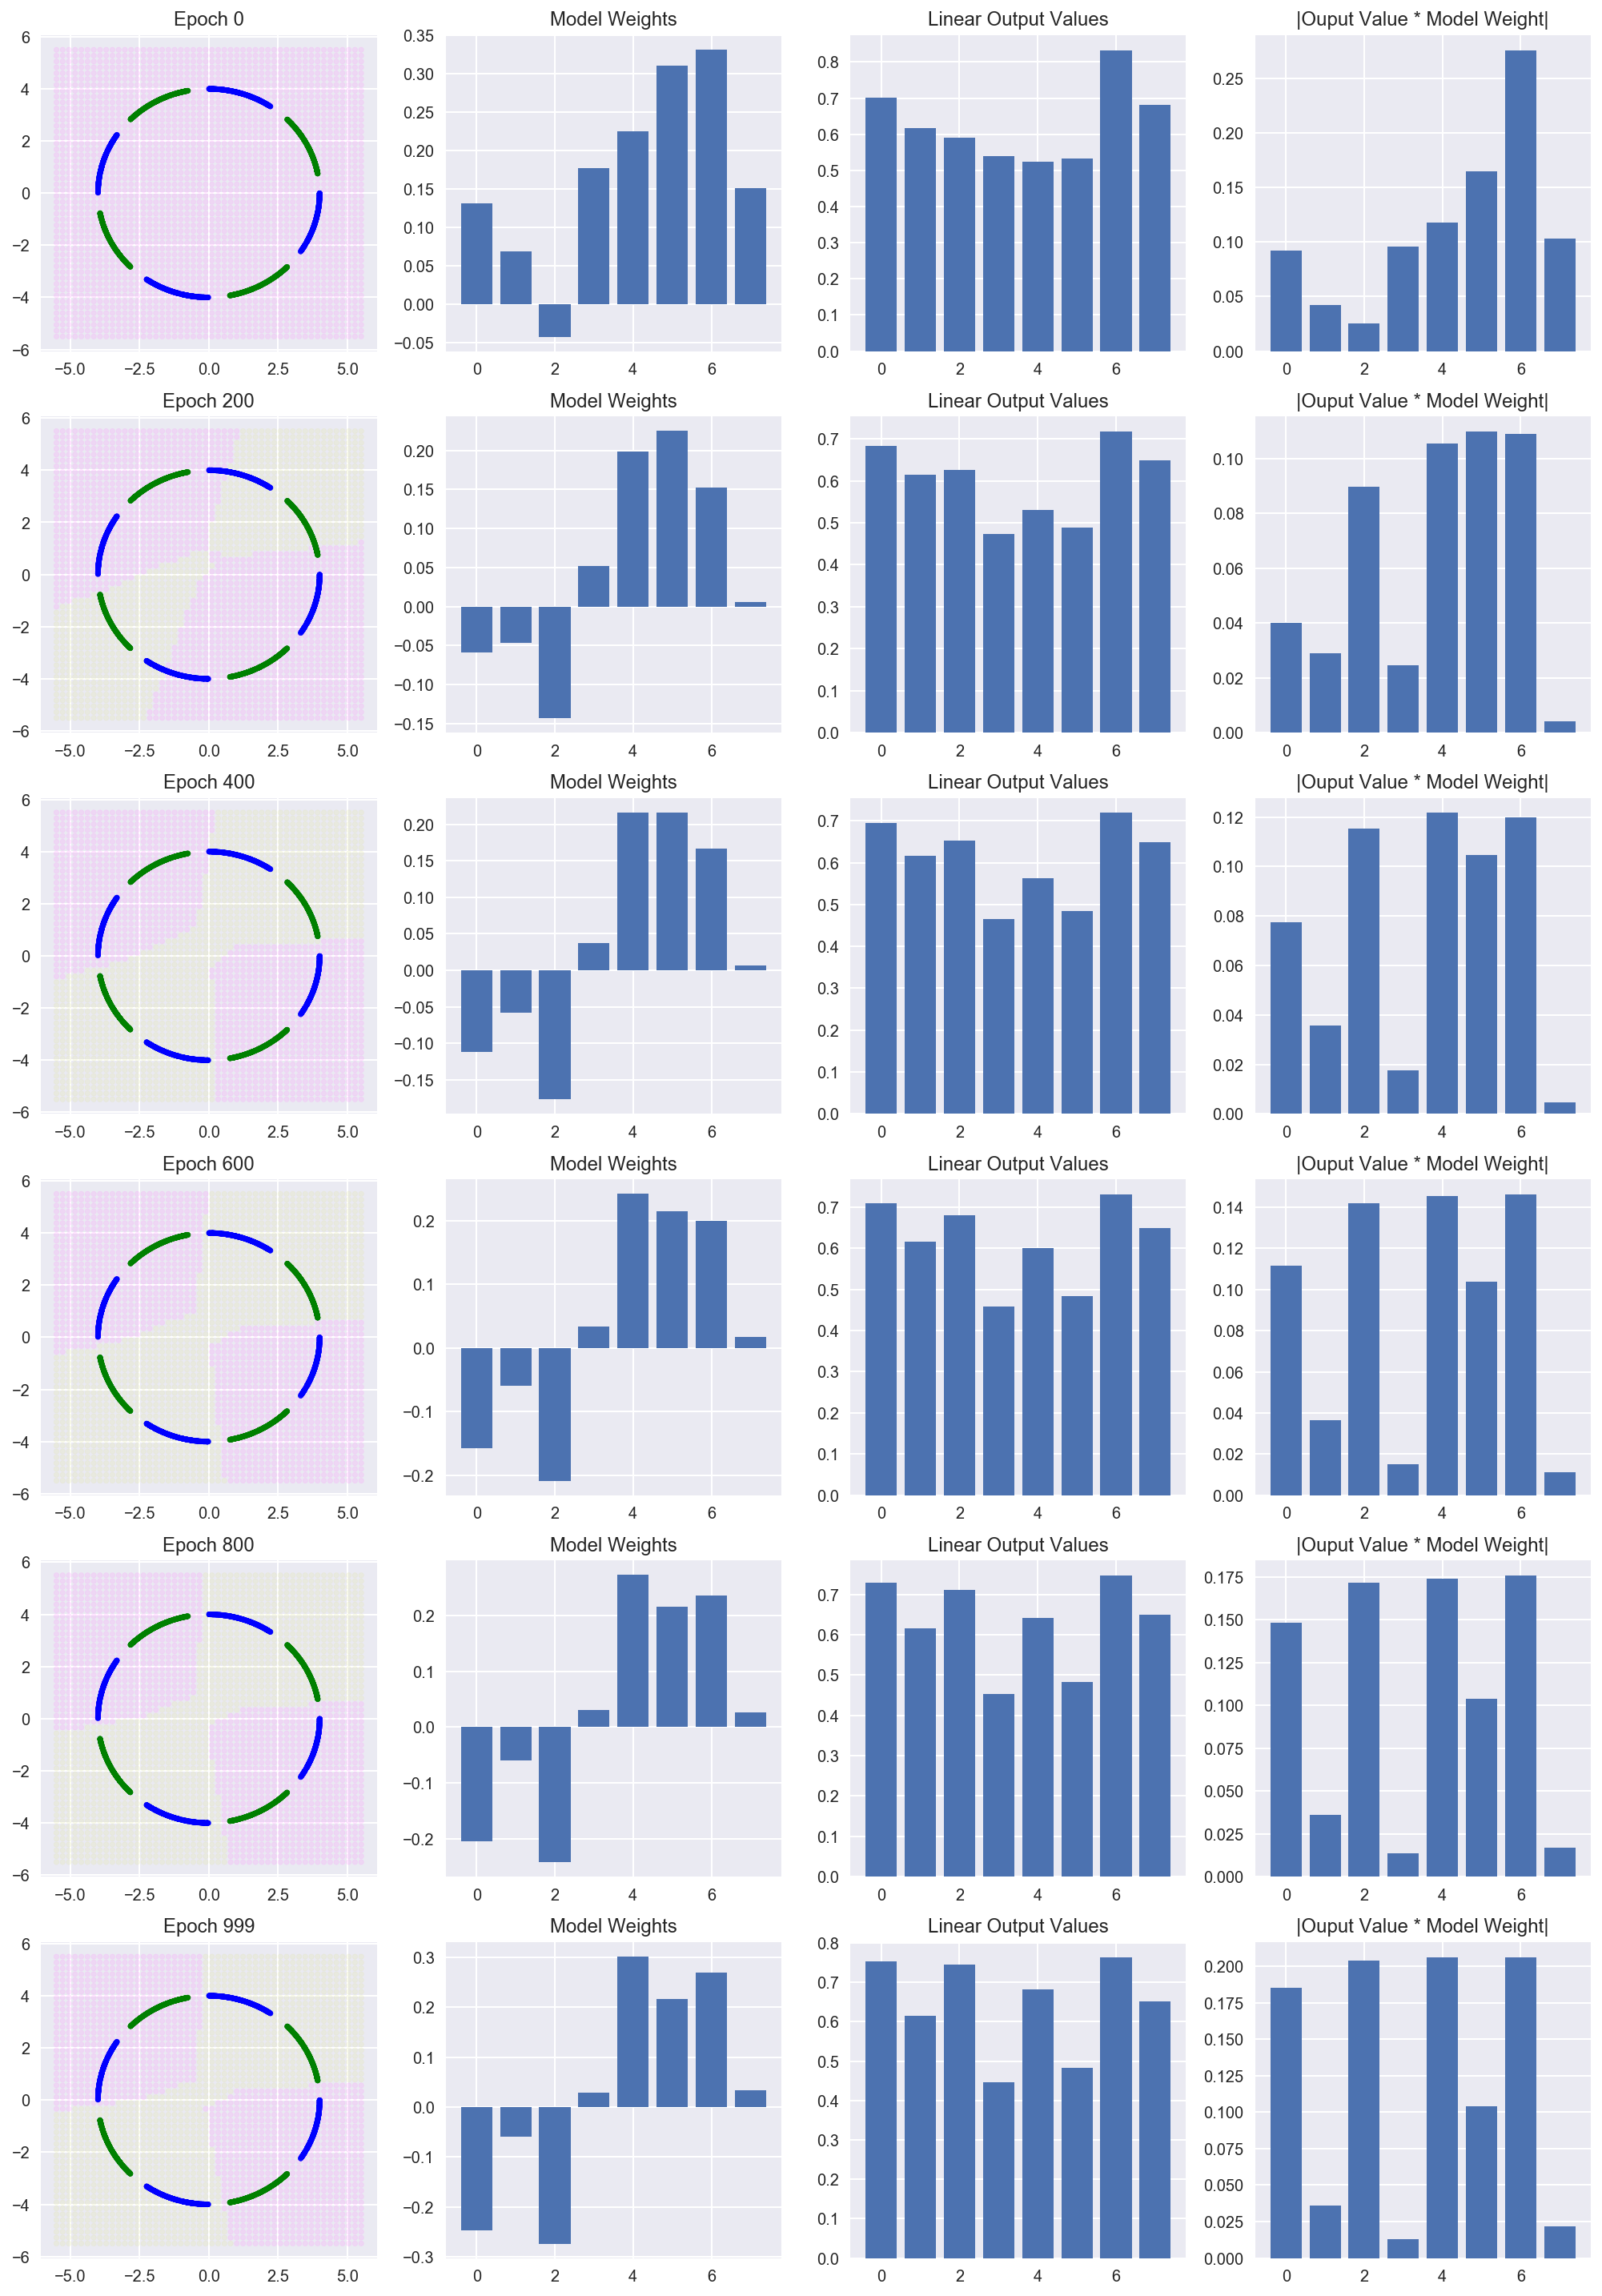

Convergence order of units []
The loss is 0.6627119183540344
Accuracy: 0.50000


Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
  (3): Sigmoid()
)

In [ ]:
model = train_run_model(x,y, sgd=True, H=8)
model

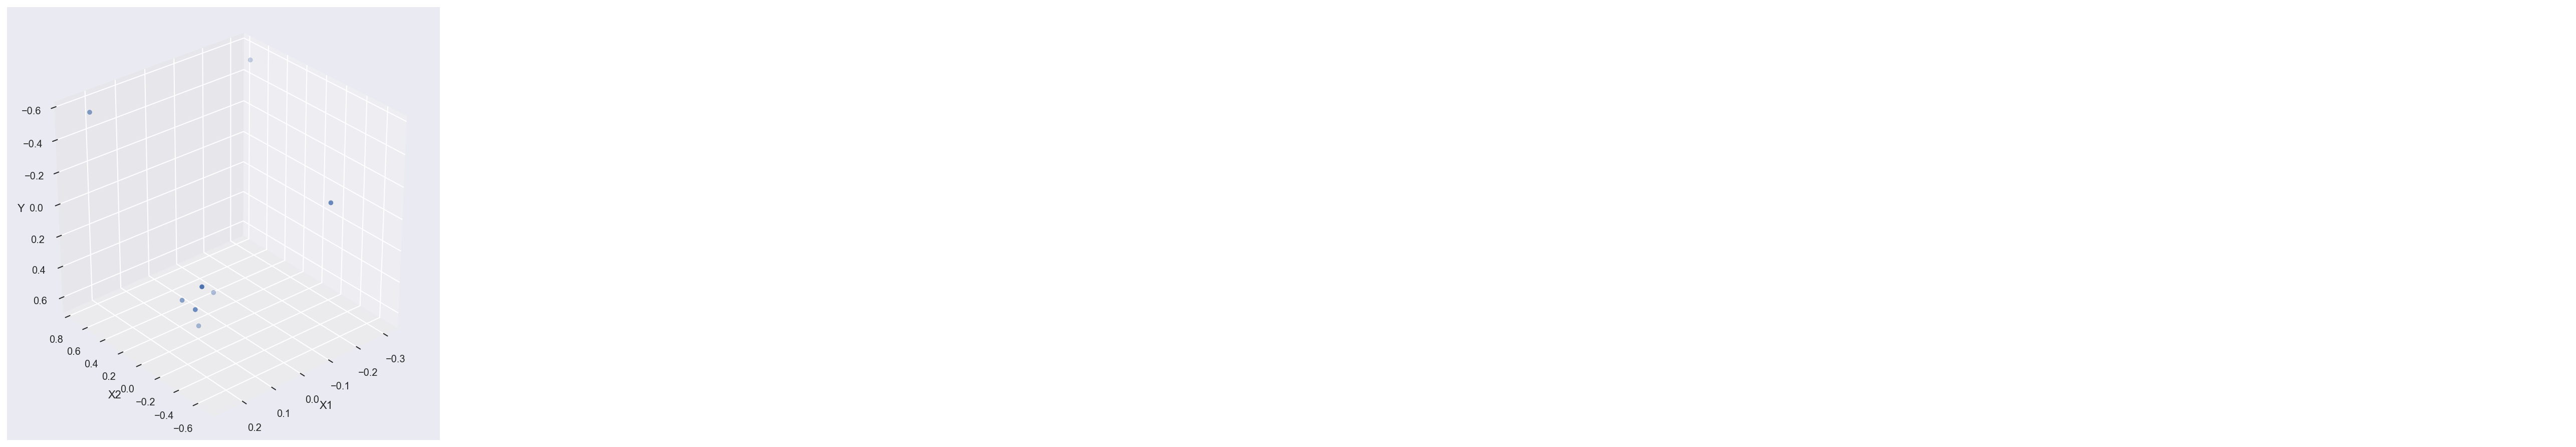

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
# ipv.pylab.xlabel('x1')
# ipv.pylab.ylabel('x1')
# ipv.pylab.zlabel('x1')

ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 3.2 SGD, ARCS = 8, H = 16

hidden unit 0 converged at epoch 1
hidden unit 3 converged at epoch 1
hidden unit 7 converged at epoch 1
hidden unit 8 converged at epoch 1
hidden unit 9 converged at epoch 1
hidden unit 10 converged at epoch 1
hidden unit 13 converged at epoch 1
hidden unit 14 converged at epoch 1
hidden unit 15 converged at epoch 1
hidden unit 0 converged at epoch 2
hidden unit 3 converged at epoch 2
hidden unit 7 converged at epoch 2
hidden unit 8 converged at epoch 2
hidden unit 9 converged at epoch 2
hidden unit 10 converged at epoch 2
hidden unit 13 converged at epoch 2
hidden unit 14 converged at epoch 2
hidden unit 15 converged at epoch 2
hidden unit 0 converged at epoch 3
hidden unit 3 converged at epoch 3
hidden unit 7 converged at epoch 3
hidden unit 8 converged at epoch 3
hidden unit 9 converged at epoch 3
hidden unit 10 converged at epoch 3
hidden unit 13 converged at epoch 3
hidden unit 14 converged at epoch 3
hidden unit 15 converged at epoch 3
hidden unit 0 converged at epoch 4
hidden u

hidden unit 0 converged at epoch 66
hidden unit 3 converged at epoch 66
hidden unit 7 converged at epoch 66
hidden unit 8 converged at epoch 66
hidden unit 9 converged at epoch 66
hidden unit 10 converged at epoch 66
hidden unit 13 converged at epoch 66
hidden unit 14 converged at epoch 66
hidden unit 15 converged at epoch 66
hidden unit 0 converged at epoch 67
hidden unit 3 converged at epoch 67
hidden unit 7 converged at epoch 67
hidden unit 8 converged at epoch 67
hidden unit 9 converged at epoch 67
hidden unit 10 converged at epoch 67
hidden unit 13 converged at epoch 67
hidden unit 14 converged at epoch 67
hidden unit 15 converged at epoch 67
hidden unit 0 converged at epoch 68
hidden unit 3 converged at epoch 68
hidden unit 7 converged at epoch 68
hidden unit 8 converged at epoch 68
hidden unit 9 converged at epoch 68
hidden unit 10 converged at epoch 68
hidden unit 13 converged at epoch 68
hidden unit 14 converged at epoch 68
hidden unit 15 converged at epoch 68
hidden unit 0 co

hidden unit 0 converged at epoch 115
hidden unit 3 converged at epoch 115
hidden unit 7 converged at epoch 115
hidden unit 8 converged at epoch 115
hidden unit 9 converged at epoch 115
hidden unit 10 converged at epoch 115
hidden unit 13 converged at epoch 115
hidden unit 14 converged at epoch 115
hidden unit 15 converged at epoch 115
hidden unit 0 converged at epoch 116
hidden unit 3 converged at epoch 116
hidden unit 7 converged at epoch 116
hidden unit 8 converged at epoch 116
hidden unit 9 converged at epoch 116
hidden unit 10 converged at epoch 116
hidden unit 13 converged at epoch 116
hidden unit 14 converged at epoch 116
hidden unit 15 converged at epoch 116
hidden unit 0 converged at epoch 117
hidden unit 3 converged at epoch 117
hidden unit 7 converged at epoch 117
hidden unit 8 converged at epoch 117
hidden unit 9 converged at epoch 117
hidden unit 10 converged at epoch 117
hidden unit 13 converged at epoch 117
hidden unit 14 converged at epoch 117
hidden unit 15 converged at

hidden unit 0 converged at epoch 167
hidden unit 3 converged at epoch 167
hidden unit 7 converged at epoch 167
hidden unit 8 converged at epoch 167
hidden unit 9 converged at epoch 167
hidden unit 10 converged at epoch 167
hidden unit 13 converged at epoch 167
hidden unit 14 converged at epoch 167
hidden unit 15 converged at epoch 167
hidden unit 0 converged at epoch 168
hidden unit 3 converged at epoch 168
hidden unit 7 converged at epoch 168
hidden unit 8 converged at epoch 168
hidden unit 9 converged at epoch 168
hidden unit 10 converged at epoch 168
hidden unit 13 converged at epoch 168
hidden unit 14 converged at epoch 168
hidden unit 15 converged at epoch 168
hidden unit 0 converged at epoch 169
hidden unit 3 converged at epoch 169
hidden unit 6 converged at epoch 169
hidden unit 7 converged at epoch 169
hidden unit 8 converged at epoch 169
hidden unit 9 converged at epoch 169
hidden unit 10 converged at epoch 169
hidden unit 13 converged at epoch 169
hidden unit 14 converged at 

hidden unit 0 converged at epoch 201
hidden unit 3 converged at epoch 201
hidden unit 6 converged at epoch 201
hidden unit 7 converged at epoch 201
hidden unit 8 converged at epoch 201
hidden unit 9 converged at epoch 201
hidden unit 10 converged at epoch 201
hidden unit 13 converged at epoch 201
hidden unit 14 converged at epoch 201
hidden unit 15 converged at epoch 201
hidden unit 0 converged at epoch 202
hidden unit 3 converged at epoch 202
hidden unit 6 converged at epoch 202
hidden unit 7 converged at epoch 202
hidden unit 8 converged at epoch 202
hidden unit 9 converged at epoch 202
hidden unit 10 converged at epoch 202
hidden unit 13 converged at epoch 202
hidden unit 14 converged at epoch 202
hidden unit 15 converged at epoch 202
hidden unit 0 converged at epoch 203
hidden unit 3 converged at epoch 203
hidden unit 6 converged at epoch 203
hidden unit 7 converged at epoch 203
hidden unit 8 converged at epoch 203
hidden unit 9 converged at epoch 203
hidden unit 10 converged at ep

hidden unit 8 converged at epoch 265
hidden unit 9 converged at epoch 265
hidden unit 10 converged at epoch 265
hidden unit 12 converged at epoch 265
hidden unit 13 converged at epoch 265
hidden unit 14 converged at epoch 265
hidden unit 15 converged at epoch 265
hidden unit 0 converged at epoch 266
hidden unit 3 converged at epoch 266
hidden unit 6 converged at epoch 266
hidden unit 7 converged at epoch 266
hidden unit 8 converged at epoch 266
hidden unit 9 converged at epoch 266
hidden unit 10 converged at epoch 266
hidden unit 12 converged at epoch 266
hidden unit 13 converged at epoch 266
hidden unit 14 converged at epoch 266
hidden unit 15 converged at epoch 266
hidden unit 0 converged at epoch 267
hidden unit 3 converged at epoch 267
hidden unit 6 converged at epoch 267
hidden unit 7 converged at epoch 267
hidden unit 8 converged at epoch 267
hidden unit 9 converged at epoch 267
hidden unit 10 converged at epoch 267
hidden unit 12 converged at epoch 267
hidden unit 13 converged a

hidden unit 15 converged at epoch 306
hidden unit 0 converged at epoch 307
hidden unit 3 converged at epoch 307
hidden unit 6 converged at epoch 307
hidden unit 7 converged at epoch 307
hidden unit 8 converged at epoch 307
hidden unit 9 converged at epoch 307
hidden unit 10 converged at epoch 307
hidden unit 12 converged at epoch 307
hidden unit 13 converged at epoch 307
hidden unit 14 converged at epoch 307
hidden unit 15 converged at epoch 307
hidden unit 0 converged at epoch 308
hidden unit 3 converged at epoch 308
hidden unit 6 converged at epoch 308
hidden unit 7 converged at epoch 308
hidden unit 8 converged at epoch 308
hidden unit 9 converged at epoch 308
hidden unit 10 converged at epoch 308
hidden unit 12 converged at epoch 308
hidden unit 13 converged at epoch 308
hidden unit 14 converged at epoch 308
hidden unit 15 converged at epoch 308
hidden unit 0 converged at epoch 309
hidden unit 3 converged at epoch 309
hidden unit 6 converged at epoch 309
hidden unit 7 converged at 

hidden unit 13 converged at epoch 357
hidden unit 14 converged at epoch 357
hidden unit 15 converged at epoch 357
hidden unit 0 converged at epoch 358
hidden unit 3 converged at epoch 358
hidden unit 5 converged at epoch 358
hidden unit 6 converged at epoch 358
hidden unit 7 converged at epoch 358
hidden unit 8 converged at epoch 358
hidden unit 9 converged at epoch 358
hidden unit 10 converged at epoch 358
hidden unit 12 converged at epoch 358
hidden unit 13 converged at epoch 358
hidden unit 14 converged at epoch 358
hidden unit 15 converged at epoch 358
hidden unit 0 converged at epoch 359
hidden unit 3 converged at epoch 359
hidden unit 5 converged at epoch 359
hidden unit 6 converged at epoch 359
hidden unit 7 converged at epoch 359
hidden unit 8 converged at epoch 359
hidden unit 9 converged at epoch 359
hidden unit 10 converged at epoch 359
hidden unit 12 converged at epoch 359
hidden unit 13 converged at epoch 359
hidden unit 14 converged at epoch 359
hidden unit 15 converged a

hidden unit 0 converged at epoch 401
hidden unit 3 converged at epoch 401
hidden unit 5 converged at epoch 401
hidden unit 6 converged at epoch 401
hidden unit 7 converged at epoch 401
hidden unit 8 converged at epoch 401
hidden unit 9 converged at epoch 401
hidden unit 10 converged at epoch 401
hidden unit 12 converged at epoch 401
hidden unit 13 converged at epoch 401
hidden unit 14 converged at epoch 401
hidden unit 15 converged at epoch 401
hidden unit 0 converged at epoch 402
hidden unit 3 converged at epoch 402
hidden unit 5 converged at epoch 402
hidden unit 6 converged at epoch 402
hidden unit 7 converged at epoch 402
hidden unit 8 converged at epoch 402
hidden unit 9 converged at epoch 402
hidden unit 10 converged at epoch 402
hidden unit 12 converged at epoch 402
hidden unit 13 converged at epoch 402
hidden unit 14 converged at epoch 402
hidden unit 15 converged at epoch 402
hidden unit 0 converged at epoch 403
hidden unit 3 converged at epoch 403
hidden unit 5 converged at e

hidden unit 9 converged at epoch 463
hidden unit 10 converged at epoch 463
hidden unit 12 converged at epoch 463
hidden unit 13 converged at epoch 463
hidden unit 14 converged at epoch 463
hidden unit 15 converged at epoch 463
hidden unit 0 converged at epoch 464
hidden unit 3 converged at epoch 464
hidden unit 5 converged at epoch 464
hidden unit 6 converged at epoch 464
hidden unit 7 converged at epoch 464
hidden unit 8 converged at epoch 464
hidden unit 9 converged at epoch 464
hidden unit 10 converged at epoch 464
hidden unit 12 converged at epoch 464
hidden unit 13 converged at epoch 464
hidden unit 14 converged at epoch 464
hidden unit 15 converged at epoch 464
hidden unit 0 converged at epoch 465
hidden unit 3 converged at epoch 465
hidden unit 5 converged at epoch 465
hidden unit 6 converged at epoch 465
hidden unit 7 converged at epoch 465
hidden unit 8 converged at epoch 465
hidden unit 9 converged at epoch 465
hidden unit 10 converged at epoch 465
hidden unit 12 converged at

hidden unit 5 converged at epoch 512
hidden unit 6 converged at epoch 512
hidden unit 7 converged at epoch 512
hidden unit 8 converged at epoch 512
hidden unit 9 converged at epoch 512
hidden unit 10 converged at epoch 512
hidden unit 11 converged at epoch 512
hidden unit 12 converged at epoch 512
hidden unit 13 converged at epoch 512
hidden unit 14 converged at epoch 512
hidden unit 15 converged at epoch 512
hidden unit 0 converged at epoch 513
hidden unit 3 converged at epoch 513
hidden unit 5 converged at epoch 513
hidden unit 6 converged at epoch 513
hidden unit 7 converged at epoch 513
hidden unit 8 converged at epoch 513
hidden unit 9 converged at epoch 513
hidden unit 10 converged at epoch 513
hidden unit 11 converged at epoch 513
hidden unit 12 converged at epoch 513
hidden unit 13 converged at epoch 513
hidden unit 14 converged at epoch 513
hidden unit 15 converged at epoch 513
hidden unit 0 converged at epoch 514
hidden unit 3 converged at epoch 514
hidden unit 5 converged at

hidden unit 13 converged at epoch 555
hidden unit 14 converged at epoch 555
hidden unit 15 converged at epoch 555
hidden unit 0 converged at epoch 556
hidden unit 3 converged at epoch 556
hidden unit 5 converged at epoch 556
hidden unit 6 converged at epoch 556
hidden unit 7 converged at epoch 556
hidden unit 8 converged at epoch 556
hidden unit 9 converged at epoch 556
hidden unit 10 converged at epoch 556
hidden unit 11 converged at epoch 556
hidden unit 12 converged at epoch 556
hidden unit 13 converged at epoch 556
hidden unit 14 converged at epoch 556
hidden unit 15 converged at epoch 556
hidden unit 0 converged at epoch 557
hidden unit 3 converged at epoch 557
hidden unit 5 converged at epoch 557
hidden unit 6 converged at epoch 557
hidden unit 7 converged at epoch 557
hidden unit 8 converged at epoch 557
hidden unit 9 converged at epoch 557
hidden unit 10 converged at epoch 557
hidden unit 11 converged at epoch 557
hidden unit 12 converged at epoch 557
hidden unit 13 converged a

hidden unit 0 converged at epoch 601
hidden unit 3 converged at epoch 601
hidden unit 5 converged at epoch 601
hidden unit 6 converged at epoch 601
hidden unit 7 converged at epoch 601
hidden unit 8 converged at epoch 601
hidden unit 9 converged at epoch 601
hidden unit 10 converged at epoch 601
hidden unit 11 converged at epoch 601
hidden unit 12 converged at epoch 601
hidden unit 13 converged at epoch 601
hidden unit 14 converged at epoch 601
hidden unit 15 converged at epoch 601
hidden unit 0 converged at epoch 602
hidden unit 3 converged at epoch 602
hidden unit 5 converged at epoch 602
hidden unit 6 converged at epoch 602
hidden unit 7 converged at epoch 602
hidden unit 8 converged at epoch 602
hidden unit 9 converged at epoch 602
hidden unit 10 converged at epoch 602
hidden unit 11 converged at epoch 602
hidden unit 12 converged at epoch 602
hidden unit 13 converged at epoch 602
hidden unit 14 converged at epoch 602
hidden unit 15 converged at epoch 602
hidden unit 0 converged at

hidden unit 5 converged at epoch 645
hidden unit 6 converged at epoch 645
hidden unit 7 converged at epoch 645
hidden unit 8 converged at epoch 645
hidden unit 9 converged at epoch 645
hidden unit 10 converged at epoch 645
hidden unit 11 converged at epoch 645
hidden unit 12 converged at epoch 645
hidden unit 13 converged at epoch 645
hidden unit 14 converged at epoch 645
hidden unit 15 converged at epoch 645
hidden unit 0 converged at epoch 646
hidden unit 3 converged at epoch 646
hidden unit 5 converged at epoch 646
hidden unit 6 converged at epoch 646
hidden unit 7 converged at epoch 646
hidden unit 8 converged at epoch 646
hidden unit 9 converged at epoch 646
hidden unit 10 converged at epoch 646
hidden unit 11 converged at epoch 646
hidden unit 12 converged at epoch 646
hidden unit 13 converged at epoch 646
hidden unit 14 converged at epoch 646
hidden unit 15 converged at epoch 646
hidden unit 0 converged at epoch 647
hidden unit 2 converged at epoch 647
hidden unit 3 converged at

hidden unit 10 converged at epoch 696
hidden unit 11 converged at epoch 696
hidden unit 12 converged at epoch 696
hidden unit 13 converged at epoch 696
hidden unit 14 converged at epoch 696
hidden unit 0 converged at epoch 697
hidden unit 2 converged at epoch 697
hidden unit 3 converged at epoch 697
hidden unit 5 converged at epoch 697
hidden unit 6 converged at epoch 697
hidden unit 7 converged at epoch 697
hidden unit 8 converged at epoch 697
hidden unit 9 converged at epoch 697
hidden unit 10 converged at epoch 697
hidden unit 11 converged at epoch 697
hidden unit 12 converged at epoch 697
hidden unit 13 converged at epoch 697
hidden unit 14 converged at epoch 697
hidden unit 0 converged at epoch 698
hidden unit 2 converged at epoch 698
hidden unit 3 converged at epoch 698
hidden unit 5 converged at epoch 698
hidden unit 6 converged at epoch 698
hidden unit 7 converged at epoch 698
hidden unit 8 converged at epoch 698
hidden unit 9 converged at epoch 698
hidden unit 10 converged at 

hidden unit 2 converged at epoch 757
hidden unit 3 converged at epoch 757
hidden unit 5 converged at epoch 757
hidden unit 6 converged at epoch 757
hidden unit 7 converged at epoch 757
hidden unit 8 converged at epoch 757
hidden unit 9 converged at epoch 757
hidden unit 10 converged at epoch 757
hidden unit 11 converged at epoch 757
hidden unit 12 converged at epoch 757
hidden unit 13 converged at epoch 757
hidden unit 14 converged at epoch 757
hidden unit 2 converged at epoch 758
hidden unit 3 converged at epoch 758
hidden unit 5 converged at epoch 758
hidden unit 6 converged at epoch 758
hidden unit 7 converged at epoch 758
hidden unit 8 converged at epoch 758
hidden unit 9 converged at epoch 758
hidden unit 10 converged at epoch 758
hidden unit 11 converged at epoch 758
hidden unit 12 converged at epoch 758
hidden unit 13 converged at epoch 758
hidden unit 14 converged at epoch 758
hidden unit 2 converged at epoch 759
hidden unit 3 converged at epoch 759
hidden unit 5 converged at e

hidden unit 2 converged at epoch 801
hidden unit 3 converged at epoch 801
hidden unit 5 converged at epoch 801
hidden unit 6 converged at epoch 801
hidden unit 7 converged at epoch 801
hidden unit 8 converged at epoch 801
hidden unit 9 converged at epoch 801
hidden unit 10 converged at epoch 801
hidden unit 11 converged at epoch 801
hidden unit 12 converged at epoch 801
hidden unit 13 converged at epoch 801
hidden unit 14 converged at epoch 801
hidden unit 2 converged at epoch 802
hidden unit 3 converged at epoch 802
hidden unit 5 converged at epoch 802
hidden unit 6 converged at epoch 802
hidden unit 7 converged at epoch 802
hidden unit 8 converged at epoch 802
hidden unit 9 converged at epoch 802
hidden unit 10 converged at epoch 802
hidden unit 11 converged at epoch 802
hidden unit 12 converged at epoch 802
hidden unit 13 converged at epoch 802
hidden unit 14 converged at epoch 802
hidden unit 2 converged at epoch 803
hidden unit 3 converged at epoch 803
hidden unit 5 converged at e

hidden unit 1 converged at epoch 846
hidden unit 2 converged at epoch 846
hidden unit 3 converged at epoch 846
hidden unit 5 converged at epoch 846
hidden unit 6 converged at epoch 846
hidden unit 7 converged at epoch 846
hidden unit 8 converged at epoch 846
hidden unit 9 converged at epoch 846
hidden unit 10 converged at epoch 846
hidden unit 11 converged at epoch 846
hidden unit 12 converged at epoch 846
hidden unit 13 converged at epoch 846
hidden unit 14 converged at epoch 846
hidden unit 1 converged at epoch 847
hidden unit 2 converged at epoch 847
hidden unit 3 converged at epoch 847
hidden unit 5 converged at epoch 847
hidden unit 6 converged at epoch 847
hidden unit 7 converged at epoch 847
hidden unit 8 converged at epoch 847
hidden unit 9 converged at epoch 847
hidden unit 10 converged at epoch 847
hidden unit 11 converged at epoch 847
hidden unit 12 converged at epoch 847
hidden unit 13 converged at epoch 847
hidden unit 14 converged at epoch 847
hidden unit 1 converged at e

hidden unit 1 converged at epoch 900
hidden unit 2 converged at epoch 900
hidden unit 3 converged at epoch 900
hidden unit 5 converged at epoch 900
hidden unit 6 converged at epoch 900
hidden unit 7 converged at epoch 900
hidden unit 8 converged at epoch 900
hidden unit 9 converged at epoch 900
hidden unit 10 converged at epoch 900
hidden unit 11 converged at epoch 900
hidden unit 12 converged at epoch 900
hidden unit 13 converged at epoch 900
hidden unit 14 converged at epoch 900
hidden unit 1 converged at epoch 901
hidden unit 2 converged at epoch 901
hidden unit 3 converged at epoch 901
hidden unit 5 converged at epoch 901
hidden unit 6 converged at epoch 901
hidden unit 7 converged at epoch 901
hidden unit 8 converged at epoch 901
hidden unit 9 converged at epoch 901
hidden unit 10 converged at epoch 901
hidden unit 11 converged at epoch 901
hidden unit 12 converged at epoch 901
hidden unit 13 converged at epoch 901
hidden unit 14 converged at epoch 901
hidden unit 1 converged at e

hidden unit 12 converged at epoch 947
hidden unit 13 converged at epoch 947
hidden unit 14 converged at epoch 947
hidden unit 1 converged at epoch 948
hidden unit 2 converged at epoch 948
hidden unit 3 converged at epoch 948
hidden unit 5 converged at epoch 948
hidden unit 6 converged at epoch 948
hidden unit 7 converged at epoch 948
hidden unit 8 converged at epoch 948
hidden unit 9 converged at epoch 948
hidden unit 10 converged at epoch 948
hidden unit 11 converged at epoch 948
hidden unit 12 converged at epoch 948
hidden unit 13 converged at epoch 948
hidden unit 14 converged at epoch 948
hidden unit 1 converged at epoch 949
hidden unit 2 converged at epoch 949
hidden unit 3 converged at epoch 949
hidden unit 5 converged at epoch 949
hidden unit 6 converged at epoch 949
hidden unit 7 converged at epoch 949
hidden unit 8 converged at epoch 949
hidden unit 9 converged at epoch 949
hidden unit 10 converged at epoch 949
hidden unit 11 converged at epoch 949
hidden unit 12 converged at 

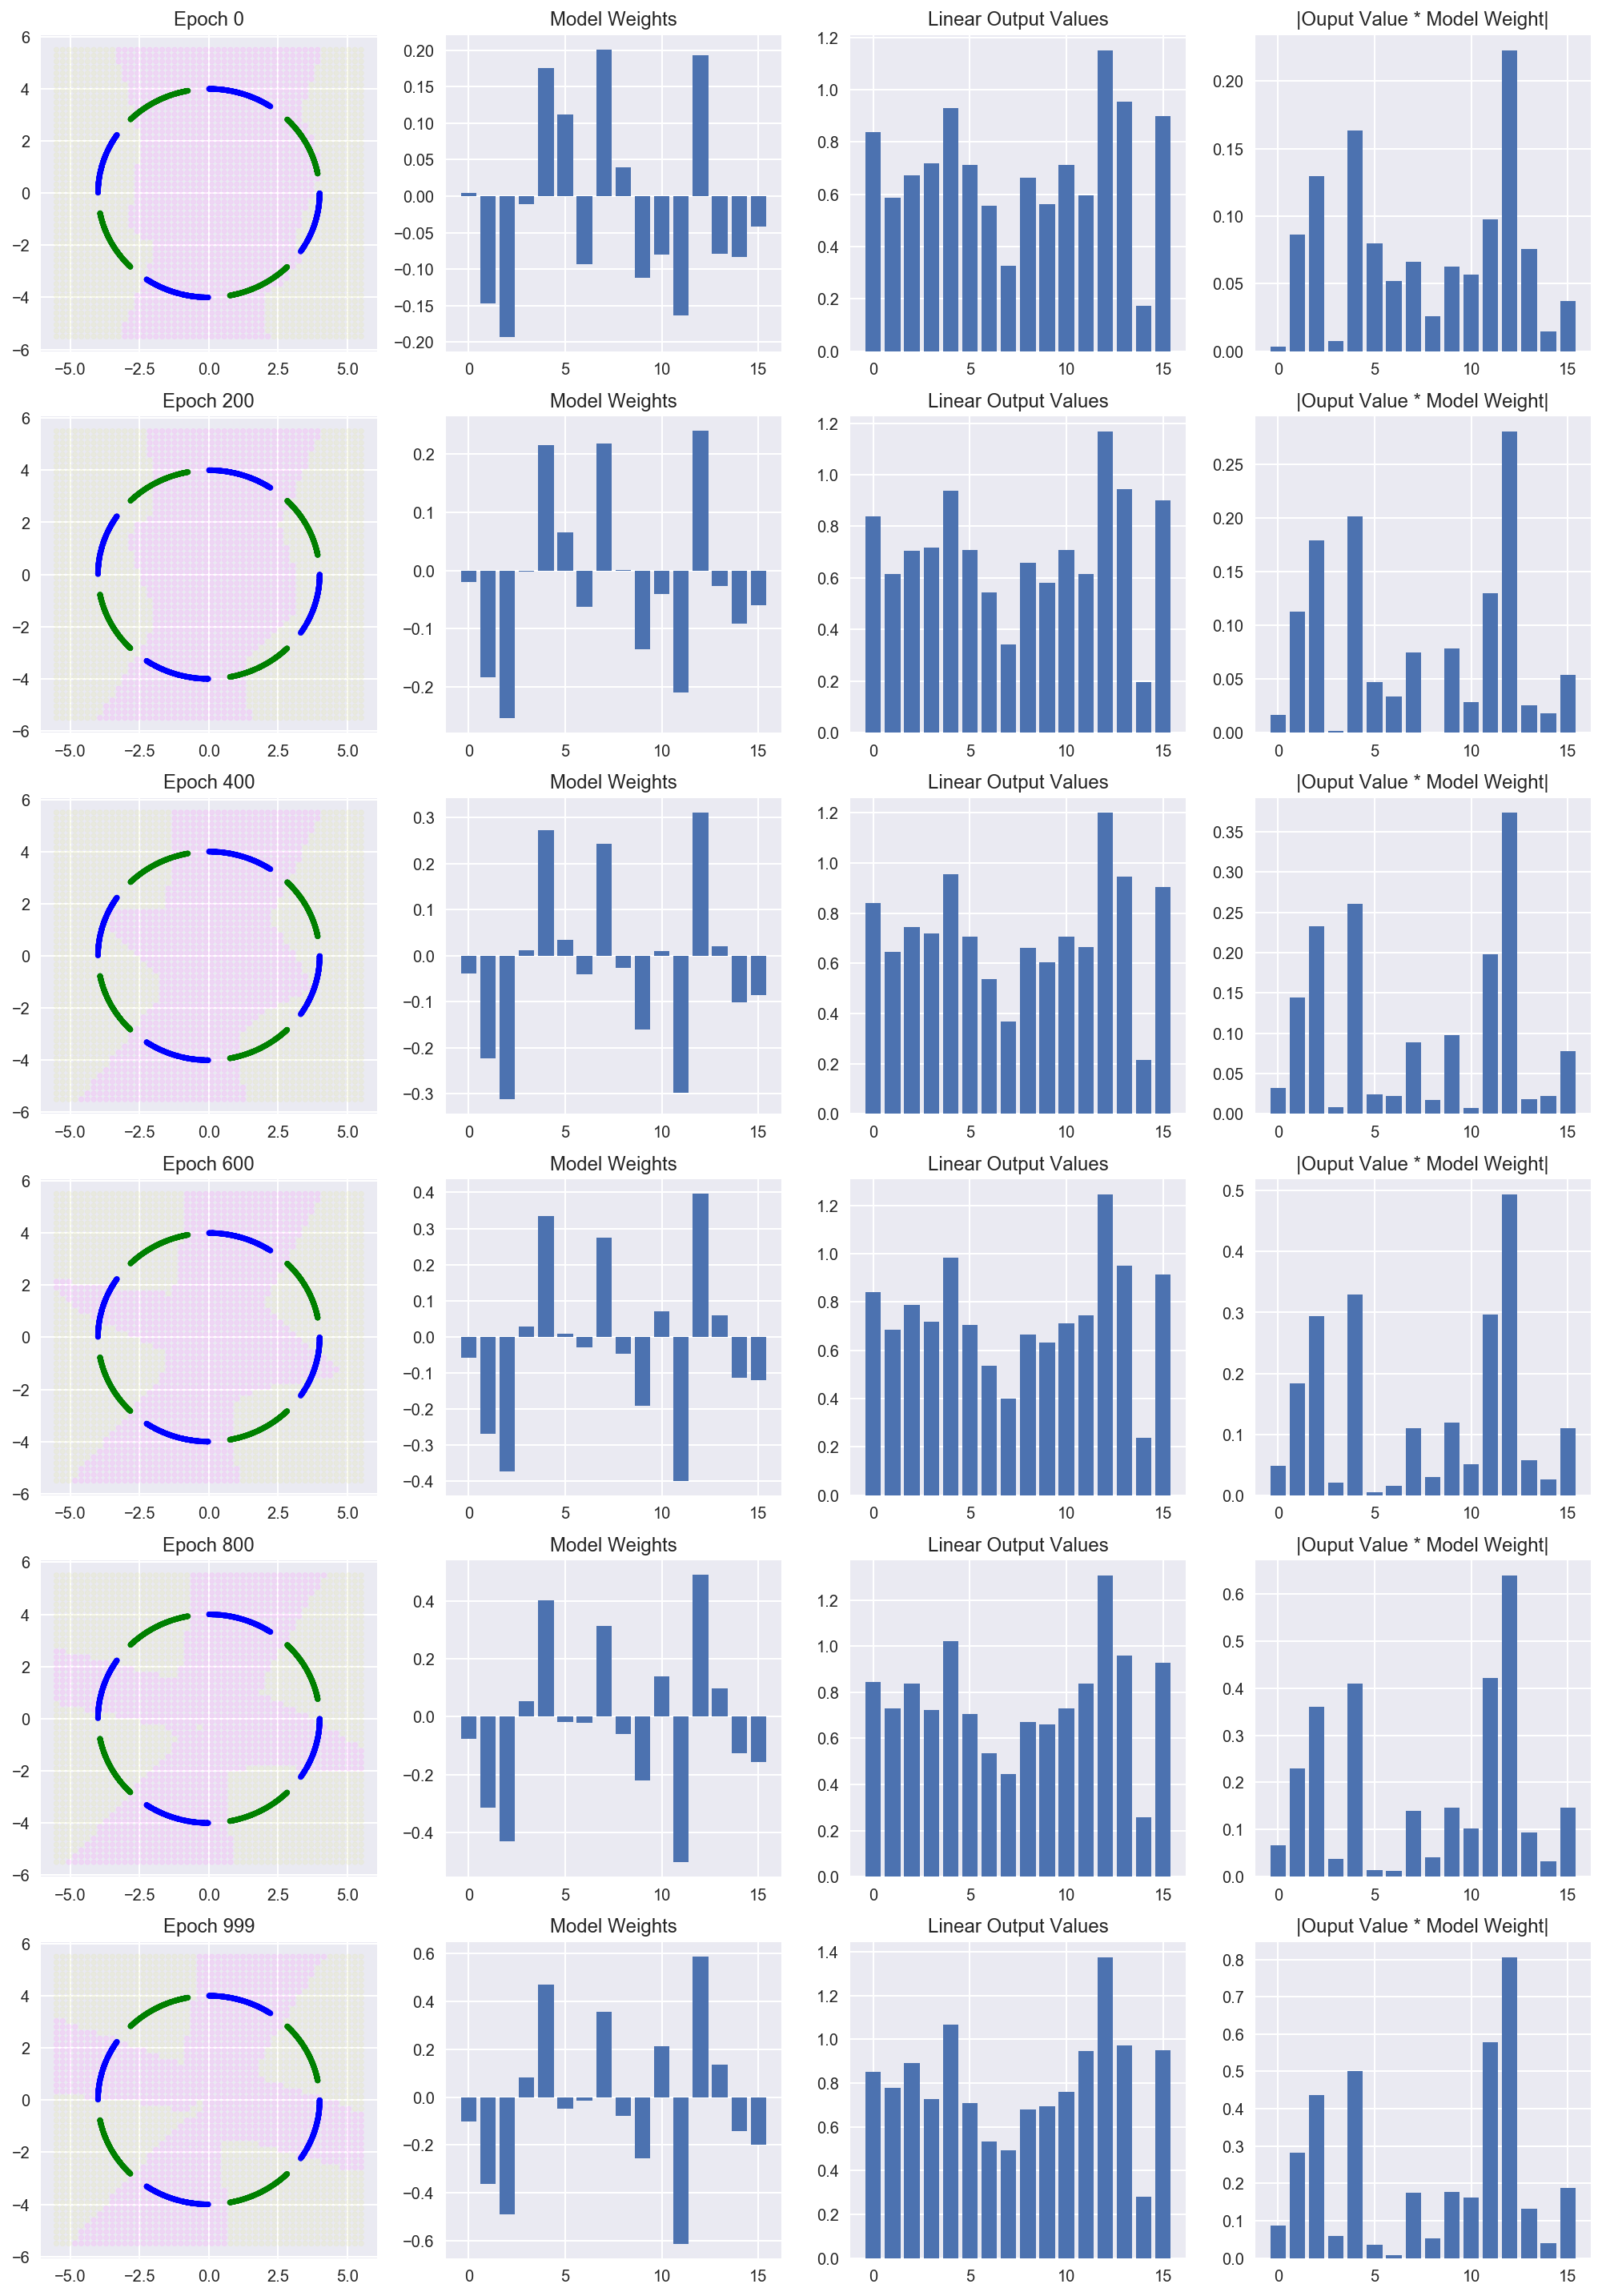

Convergence order of units []
The loss is 0.540622889995575
Accuracy: 0.99571


Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
  (3): Sigmoid()
)

In [ ]:
model = train_run_model(x,y, sgd=True, H=16)
model

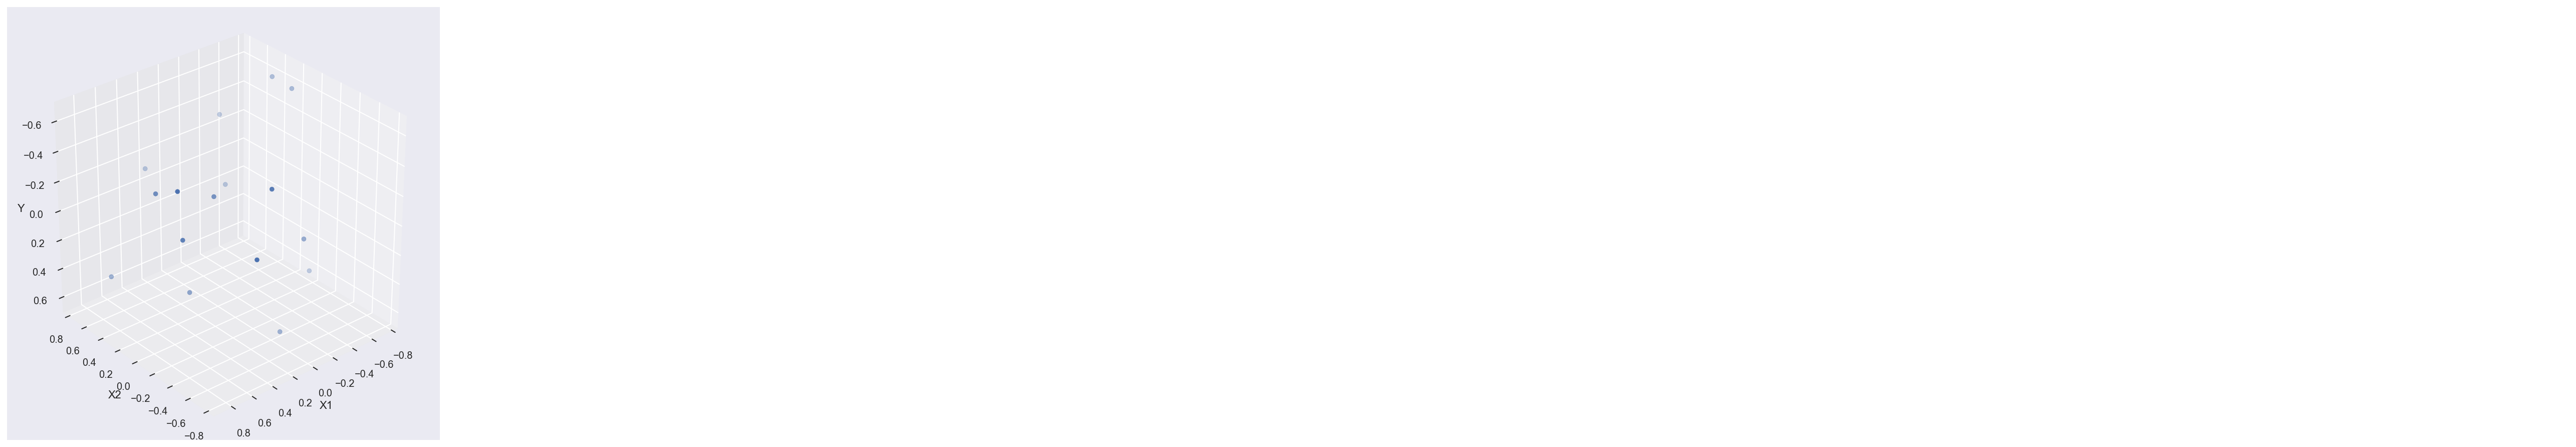

In [ ]:
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 3.3 SGD, ARCS = 8, H = 32

In [ ]:
model = train_run_model(x,y, sgd=True, H=32)
model

hidden unit 3 converged at epoch 1
hidden unit 4 converged at epoch 1
hidden unit 5 converged at epoch 1
hidden unit 6 converged at epoch 1
hidden unit 7 converged at epoch 1
hidden unit 10 converged at epoch 1
hidden unit 11 converged at epoch 1
hidden unit 12 converged at epoch 1
hidden unit 13 converged at epoch 1
hidden unit 15 converged at epoch 1
hidden unit 16 converged at epoch 1
hidden unit 17 converged at epoch 1
hidden unit 19 converged at epoch 1
hidden unit 22 converged at epoch 1
hidden unit 24 converged at epoch 1
hidden unit 26 converged at epoch 1
hidden unit 28 converged at epoch 1
hidden unit 30 converged at epoch 1
hidden unit 31 converged at epoch 1
hidden unit 3 converged at epoch 2
hidden unit 4 converged at epoch 2
hidden unit 5 converged at epoch 2
hidden unit 6 converged at epoch 2
hidden unit 7 converged at epoch 2
hidden unit 10 converged at epoch 2
hidden unit 11 converged at epoch 2
hidden unit 12 converged at epoch 2
hidden unit 13 converged at epoch 2
hi

hidden unit 15 converged at epoch 39
hidden unit 16 converged at epoch 39
hidden unit 17 converged at epoch 39
hidden unit 18 converged at epoch 39
hidden unit 19 converged at epoch 39
hidden unit 20 converged at epoch 39
hidden unit 22 converged at epoch 39
hidden unit 23 converged at epoch 39
hidden unit 24 converged at epoch 39
hidden unit 25 converged at epoch 39
hidden unit 26 converged at epoch 39
hidden unit 28 converged at epoch 39
hidden unit 30 converged at epoch 39
hidden unit 0 converged at epoch 40
hidden unit 3 converged at epoch 40
hidden unit 4 converged at epoch 40
hidden unit 6 converged at epoch 40
hidden unit 7 converged at epoch 40
hidden unit 8 converged at epoch 40
hidden unit 10 converged at epoch 40
hidden unit 11 converged at epoch 40
hidden unit 12 converged at epoch 40
hidden unit 13 converged at epoch 40
hidden unit 15 converged at epoch 40
hidden unit 16 converged at epoch 40
hidden unit 17 converged at epoch 40
hidden unit 18 converged at epoch 40
hidden 

hidden unit 7 converged at epoch 74
hidden unit 8 converged at epoch 74
hidden unit 11 converged at epoch 74
hidden unit 12 converged at epoch 74
hidden unit 13 converged at epoch 74
hidden unit 14 converged at epoch 74
hidden unit 15 converged at epoch 74
hidden unit 16 converged at epoch 74
hidden unit 17 converged at epoch 74
hidden unit 18 converged at epoch 74
hidden unit 19 converged at epoch 74
hidden unit 20 converged at epoch 74
hidden unit 22 converged at epoch 74
hidden unit 23 converged at epoch 74
hidden unit 24 converged at epoch 74
hidden unit 25 converged at epoch 74
hidden unit 26 converged at epoch 74
hidden unit 27 converged at epoch 74
hidden unit 28 converged at epoch 74
hidden unit 29 converged at epoch 74
hidden unit 30 converged at epoch 74
hidden unit 31 converged at epoch 74
hidden unit 0 converged at epoch 75
hidden unit 2 converged at epoch 75
hidden unit 3 converged at epoch 75
hidden unit 4 converged at epoch 75
hidden unit 6 converged at epoch 75
hidden u

hidden unit 13 converged at epoch 99
hidden unit 14 converged at epoch 99
hidden unit 15 converged at epoch 99
hidden unit 16 converged at epoch 99
hidden unit 17 converged at epoch 99
hidden unit 18 converged at epoch 99
hidden unit 19 converged at epoch 99
hidden unit 20 converged at epoch 99
hidden unit 22 converged at epoch 99
hidden unit 23 converged at epoch 99
hidden unit 24 converged at epoch 99
hidden unit 25 converged at epoch 99
hidden unit 26 converged at epoch 99
hidden unit 27 converged at epoch 99
hidden unit 28 converged at epoch 99
hidden unit 29 converged at epoch 99
hidden unit 30 converged at epoch 99
hidden unit 31 converged at epoch 99
hidden unit 0 converged at epoch 100
hidden unit 2 converged at epoch 100
hidden unit 3 converged at epoch 100
hidden unit 4 converged at epoch 100
hidden unit 6 converged at epoch 100
hidden unit 7 converged at epoch 100
hidden unit 8 converged at epoch 100
hidden unit 11 converged at epoch 100
hidden unit 12 converged at epoch 100

hidden unit 6 converged at epoch 127
hidden unit 7 converged at epoch 127
hidden unit 8 converged at epoch 127
hidden unit 11 converged at epoch 127
hidden unit 12 converged at epoch 127
hidden unit 13 converged at epoch 127
hidden unit 14 converged at epoch 127
hidden unit 15 converged at epoch 127
hidden unit 16 converged at epoch 127
hidden unit 17 converged at epoch 127
hidden unit 18 converged at epoch 127
hidden unit 19 converged at epoch 127
hidden unit 20 converged at epoch 127
hidden unit 22 converged at epoch 127
hidden unit 23 converged at epoch 127
hidden unit 24 converged at epoch 127
hidden unit 25 converged at epoch 127
hidden unit 26 converged at epoch 127
hidden unit 27 converged at epoch 127
hidden unit 28 converged at epoch 127
hidden unit 29 converged at epoch 127
hidden unit 30 converged at epoch 127
hidden unit 31 converged at epoch 127
hidden unit 0 converged at epoch 128
hidden unit 2 converged at epoch 128
hidden unit 3 converged at epoch 128
hidden unit 4 conv

hidden unit 26 converged at epoch 162
hidden unit 27 converged at epoch 162
hidden unit 28 converged at epoch 162
hidden unit 29 converged at epoch 162
hidden unit 30 converged at epoch 162
hidden unit 31 converged at epoch 162
hidden unit 0 converged at epoch 163
hidden unit 2 converged at epoch 163
hidden unit 3 converged at epoch 163
hidden unit 4 converged at epoch 163
hidden unit 6 converged at epoch 163
hidden unit 7 converged at epoch 163
hidden unit 8 converged at epoch 163
hidden unit 12 converged at epoch 163
hidden unit 13 converged at epoch 163
hidden unit 15 converged at epoch 163
hidden unit 16 converged at epoch 163
hidden unit 17 converged at epoch 163
hidden unit 18 converged at epoch 163
hidden unit 19 converged at epoch 163
hidden unit 20 converged at epoch 163
hidden unit 22 converged at epoch 163
hidden unit 23 converged at epoch 163
hidden unit 24 converged at epoch 163
hidden unit 25 converged at epoch 163
hidden unit 26 converged at epoch 163
hidden unit 27 conv

hidden unit 15 converged at epoch 190
hidden unit 16 converged at epoch 190
hidden unit 17 converged at epoch 190
hidden unit 18 converged at epoch 190
hidden unit 19 converged at epoch 190
hidden unit 20 converged at epoch 190
hidden unit 22 converged at epoch 190
hidden unit 23 converged at epoch 190
hidden unit 24 converged at epoch 190
hidden unit 25 converged at epoch 190
hidden unit 26 converged at epoch 190
hidden unit 27 converged at epoch 190
hidden unit 28 converged at epoch 190
hidden unit 29 converged at epoch 190
hidden unit 30 converged at epoch 190
hidden unit 31 converged at epoch 190
hidden unit 0 converged at epoch 191
hidden unit 2 converged at epoch 191
hidden unit 3 converged at epoch 191
hidden unit 4 converged at epoch 191
hidden unit 6 converged at epoch 191
hidden unit 7 converged at epoch 191
hidden unit 8 converged at epoch 191
hidden unit 12 converged at epoch 191
hidden unit 13 converged at epoch 191
hidden unit 15 converged at epoch 191
hidden unit 16 conv

hidden unit 0 converged at epoch 201
hidden unit 2 converged at epoch 201
hidden unit 3 converged at epoch 201
hidden unit 4 converged at epoch 201
hidden unit 6 converged at epoch 201
hidden unit 7 converged at epoch 201
hidden unit 8 converged at epoch 201
hidden unit 12 converged at epoch 201
hidden unit 13 converged at epoch 201
hidden unit 15 converged at epoch 201
hidden unit 16 converged at epoch 201
hidden unit 17 converged at epoch 201
hidden unit 18 converged at epoch 201
hidden unit 19 converged at epoch 201
hidden unit 20 converged at epoch 201
hidden unit 22 converged at epoch 201
hidden unit 23 converged at epoch 201
hidden unit 24 converged at epoch 201
hidden unit 25 converged at epoch 201
hidden unit 26 converged at epoch 201
hidden unit 27 converged at epoch 201
hidden unit 28 converged at epoch 201
hidden unit 29 converged at epoch 201
hidden unit 30 converged at epoch 201
hidden unit 31 converged at epoch 201
hidden unit 0 converged at epoch 202
hidden unit 2 conver

hidden unit 15 converged at epoch 235
hidden unit 16 converged at epoch 235
hidden unit 17 converged at epoch 235
hidden unit 18 converged at epoch 235
hidden unit 19 converged at epoch 235
hidden unit 20 converged at epoch 235
hidden unit 22 converged at epoch 235
hidden unit 23 converged at epoch 235
hidden unit 24 converged at epoch 235
hidden unit 25 converged at epoch 235
hidden unit 26 converged at epoch 235
hidden unit 27 converged at epoch 235
hidden unit 28 converged at epoch 235
hidden unit 29 converged at epoch 235
hidden unit 30 converged at epoch 235
hidden unit 31 converged at epoch 235
hidden unit 0 converged at epoch 236
hidden unit 2 converged at epoch 236
hidden unit 3 converged at epoch 236
hidden unit 4 converged at epoch 236
hidden unit 6 converged at epoch 236
hidden unit 7 converged at epoch 236
hidden unit 8 converged at epoch 236
hidden unit 12 converged at epoch 236
hidden unit 13 converged at epoch 236
hidden unit 15 converged at epoch 236
hidden unit 16 conv

hidden unit 16 converged at epoch 269
hidden unit 17 converged at epoch 269
hidden unit 18 converged at epoch 269
hidden unit 19 converged at epoch 269
hidden unit 20 converged at epoch 269
hidden unit 22 converged at epoch 269
hidden unit 23 converged at epoch 269
hidden unit 24 converged at epoch 269
hidden unit 25 converged at epoch 269
hidden unit 26 converged at epoch 269
hidden unit 27 converged at epoch 269
hidden unit 28 converged at epoch 269
hidden unit 29 converged at epoch 269
hidden unit 30 converged at epoch 269
hidden unit 31 converged at epoch 269
hidden unit 0 converged at epoch 270
hidden unit 2 converged at epoch 270
hidden unit 3 converged at epoch 270
hidden unit 4 converged at epoch 270
hidden unit 6 converged at epoch 270
hidden unit 7 converged at epoch 270
hidden unit 8 converged at epoch 270
hidden unit 12 converged at epoch 270
hidden unit 13 converged at epoch 270
hidden unit 15 converged at epoch 270
hidden unit 16 converged at epoch 270
hidden unit 17 conv

hidden unit 4 converged at epoch 302
hidden unit 6 converged at epoch 302
hidden unit 7 converged at epoch 302
hidden unit 8 converged at epoch 302
hidden unit 12 converged at epoch 302
hidden unit 13 converged at epoch 302
hidden unit 15 converged at epoch 302
hidden unit 16 converged at epoch 302
hidden unit 17 converged at epoch 302
hidden unit 18 converged at epoch 302
hidden unit 19 converged at epoch 302
hidden unit 20 converged at epoch 302
hidden unit 22 converged at epoch 302
hidden unit 23 converged at epoch 302
hidden unit 24 converged at epoch 302
hidden unit 25 converged at epoch 302
hidden unit 26 converged at epoch 302
hidden unit 27 converged at epoch 302
hidden unit 28 converged at epoch 302
hidden unit 29 converged at epoch 302
hidden unit 30 converged at epoch 302
hidden unit 31 converged at epoch 302
hidden unit 0 converged at epoch 303
hidden unit 2 converged at epoch 303
hidden unit 3 converged at epoch 303
hidden unit 4 converged at epoch 303
hidden unit 6 conver

hidden unit 13 converged at epoch 333
hidden unit 15 converged at epoch 333
hidden unit 16 converged at epoch 333
hidden unit 17 converged at epoch 333
hidden unit 19 converged at epoch 333
hidden unit 20 converged at epoch 333
hidden unit 22 converged at epoch 333
hidden unit 23 converged at epoch 333
hidden unit 24 converged at epoch 333
hidden unit 25 converged at epoch 333
hidden unit 26 converged at epoch 333
hidden unit 27 converged at epoch 333
hidden unit 28 converged at epoch 333
hidden unit 29 converged at epoch 333
hidden unit 30 converged at epoch 333
hidden unit 31 converged at epoch 333
hidden unit 0 converged at epoch 334
hidden unit 2 converged at epoch 334
hidden unit 3 converged at epoch 334
hidden unit 4 converged at epoch 334
hidden unit 6 converged at epoch 334
hidden unit 7 converged at epoch 334
hidden unit 8 converged at epoch 334
hidden unit 12 converged at epoch 334
hidden unit 13 converged at epoch 334
hidden unit 15 converged at epoch 334
hidden unit 16 conv

hidden unit 0 converged at epoch 356
hidden unit 2 converged at epoch 356
hidden unit 3 converged at epoch 356
hidden unit 4 converged at epoch 356
hidden unit 6 converged at epoch 356
hidden unit 7 converged at epoch 356
hidden unit 8 converged at epoch 356
hidden unit 12 converged at epoch 356
hidden unit 15 converged at epoch 356
hidden unit 16 converged at epoch 356
hidden unit 17 converged at epoch 356
hidden unit 19 converged at epoch 356
hidden unit 20 converged at epoch 356
hidden unit 22 converged at epoch 356
hidden unit 23 converged at epoch 356
hidden unit 24 converged at epoch 356
hidden unit 25 converged at epoch 356
hidden unit 26 converged at epoch 356
hidden unit 27 converged at epoch 356
hidden unit 28 converged at epoch 356
hidden unit 29 converged at epoch 356
hidden unit 30 converged at epoch 356
hidden unit 31 converged at epoch 356
hidden unit 0 converged at epoch 357
hidden unit 2 converged at epoch 357
hidden unit 3 converged at epoch 357
hidden unit 4 converge

hidden unit 27 converged at epoch 375
hidden unit 28 converged at epoch 375
hidden unit 29 converged at epoch 375
hidden unit 30 converged at epoch 375
hidden unit 31 converged at epoch 375
hidden unit 0 converged at epoch 376
hidden unit 2 converged at epoch 376
hidden unit 3 converged at epoch 376
hidden unit 4 converged at epoch 376
hidden unit 6 converged at epoch 376
hidden unit 7 converged at epoch 376
hidden unit 8 converged at epoch 376
hidden unit 12 converged at epoch 376
hidden unit 15 converged at epoch 376
hidden unit 16 converged at epoch 376
hidden unit 17 converged at epoch 376
hidden unit 19 converged at epoch 376
hidden unit 20 converged at epoch 376
hidden unit 22 converged at epoch 376
hidden unit 23 converged at epoch 376
hidden unit 24 converged at epoch 376
hidden unit 25 converged at epoch 376
hidden unit 26 converged at epoch 376
hidden unit 27 converged at epoch 376
hidden unit 28 converged at epoch 376
hidden unit 29 converged at epoch 376
hidden unit 30 conv

hidden unit 0 converged at epoch 401
hidden unit 2 converged at epoch 401
hidden unit 3 converged at epoch 401
hidden unit 4 converged at epoch 401
hidden unit 6 converged at epoch 401
hidden unit 7 converged at epoch 401
hidden unit 8 converged at epoch 401
hidden unit 12 converged at epoch 401
hidden unit 15 converged at epoch 401
hidden unit 16 converged at epoch 401
hidden unit 17 converged at epoch 401
hidden unit 19 converged at epoch 401
hidden unit 20 converged at epoch 401
hidden unit 22 converged at epoch 401
hidden unit 23 converged at epoch 401
hidden unit 24 converged at epoch 401
hidden unit 25 converged at epoch 401
hidden unit 26 converged at epoch 401
hidden unit 27 converged at epoch 401
hidden unit 28 converged at epoch 401
hidden unit 29 converged at epoch 401
hidden unit 30 converged at epoch 401
hidden unit 31 converged at epoch 401
hidden unit 0 converged at epoch 402
hidden unit 2 converged at epoch 402
hidden unit 3 converged at epoch 402
hidden unit 4 converge

hidden unit 15 converged at epoch 436
hidden unit 16 converged at epoch 436
hidden unit 17 converged at epoch 436
hidden unit 19 converged at epoch 436
hidden unit 20 converged at epoch 436
hidden unit 22 converged at epoch 436
hidden unit 23 converged at epoch 436
hidden unit 24 converged at epoch 436
hidden unit 25 converged at epoch 436
hidden unit 26 converged at epoch 436
hidden unit 27 converged at epoch 436
hidden unit 28 converged at epoch 436
hidden unit 29 converged at epoch 436
hidden unit 30 converged at epoch 436
hidden unit 31 converged at epoch 436
hidden unit 0 converged at epoch 437
hidden unit 3 converged at epoch 437
hidden unit 4 converged at epoch 437
hidden unit 6 converged at epoch 437
hidden unit 7 converged at epoch 437
hidden unit 8 converged at epoch 437
hidden unit 12 converged at epoch 437
hidden unit 15 converged at epoch 437
hidden unit 16 converged at epoch 437
hidden unit 17 converged at epoch 437
hidden unit 19 converged at epoch 437
hidden unit 20 con

hidden unit 0 converged at epoch 472
hidden unit 3 converged at epoch 472
hidden unit 4 converged at epoch 472
hidden unit 6 converged at epoch 472
hidden unit 7 converged at epoch 472
hidden unit 8 converged at epoch 472
hidden unit 12 converged at epoch 472
hidden unit 15 converged at epoch 472
hidden unit 16 converged at epoch 472
hidden unit 17 converged at epoch 472
hidden unit 19 converged at epoch 472
hidden unit 20 converged at epoch 472
hidden unit 22 converged at epoch 472
hidden unit 23 converged at epoch 472
hidden unit 24 converged at epoch 472
hidden unit 25 converged at epoch 472
hidden unit 26 converged at epoch 472
hidden unit 27 converged at epoch 472
hidden unit 28 converged at epoch 472
hidden unit 29 converged at epoch 472
hidden unit 30 converged at epoch 472
hidden unit 31 converged at epoch 472
hidden unit 0 converged at epoch 473
hidden unit 3 converged at epoch 473
hidden unit 4 converged at epoch 473
hidden unit 6 converged at epoch 473
hidden unit 7 converge

hidden unit 0 converged at epoch 508
hidden unit 3 converged at epoch 508
hidden unit 4 converged at epoch 508
hidden unit 6 converged at epoch 508
hidden unit 7 converged at epoch 508
hidden unit 8 converged at epoch 508
hidden unit 12 converged at epoch 508
hidden unit 15 converged at epoch 508
hidden unit 16 converged at epoch 508
hidden unit 17 converged at epoch 508
hidden unit 19 converged at epoch 508
hidden unit 20 converged at epoch 508
hidden unit 22 converged at epoch 508
hidden unit 23 converged at epoch 508
hidden unit 24 converged at epoch 508
hidden unit 25 converged at epoch 508
hidden unit 26 converged at epoch 508
hidden unit 27 converged at epoch 508
hidden unit 28 converged at epoch 508
hidden unit 29 converged at epoch 508
hidden unit 30 converged at epoch 508
hidden unit 31 converged at epoch 508
hidden unit 0 converged at epoch 509
hidden unit 3 converged at epoch 509
hidden unit 4 converged at epoch 509
hidden unit 6 converged at epoch 509
hidden unit 7 converge

hidden unit 20 converged at epoch 544
hidden unit 22 converged at epoch 544
hidden unit 23 converged at epoch 544
hidden unit 24 converged at epoch 544
hidden unit 25 converged at epoch 544
hidden unit 26 converged at epoch 544
hidden unit 27 converged at epoch 544
hidden unit 28 converged at epoch 544
hidden unit 29 converged at epoch 544
hidden unit 30 converged at epoch 544
hidden unit 31 converged at epoch 544
hidden unit 0 converged at epoch 545
hidden unit 3 converged at epoch 545
hidden unit 4 converged at epoch 545
hidden unit 6 converged at epoch 545
hidden unit 7 converged at epoch 545
hidden unit 8 converged at epoch 545
hidden unit 12 converged at epoch 545
hidden unit 15 converged at epoch 545
hidden unit 16 converged at epoch 545
hidden unit 17 converged at epoch 545
hidden unit 19 converged at epoch 545
hidden unit 20 converged at epoch 545
hidden unit 22 converged at epoch 545
hidden unit 23 converged at epoch 545
hidden unit 24 converged at epoch 545
hidden unit 25 con

hidden unit 22 converged at epoch 577
hidden unit 23 converged at epoch 577
hidden unit 24 converged at epoch 577
hidden unit 25 converged at epoch 577
hidden unit 26 converged at epoch 577
hidden unit 27 converged at epoch 577
hidden unit 28 converged at epoch 577
hidden unit 29 converged at epoch 577
hidden unit 30 converged at epoch 577
hidden unit 31 converged at epoch 577
hidden unit 0 converged at epoch 578
hidden unit 3 converged at epoch 578
hidden unit 4 converged at epoch 578
hidden unit 6 converged at epoch 578
hidden unit 7 converged at epoch 578
hidden unit 8 converged at epoch 578
hidden unit 12 converged at epoch 578
hidden unit 15 converged at epoch 578
hidden unit 16 converged at epoch 578
hidden unit 17 converged at epoch 578
hidden unit 19 converged at epoch 578
hidden unit 20 converged at epoch 578
hidden unit 22 converged at epoch 578
hidden unit 23 converged at epoch 578
hidden unit 24 converged at epoch 578
hidden unit 25 converged at epoch 578
hidden unit 26 con

hidden unit 0 converged at epoch 601
hidden unit 3 converged at epoch 601
hidden unit 4 converged at epoch 601
hidden unit 6 converged at epoch 601
hidden unit 7 converged at epoch 601
hidden unit 8 converged at epoch 601
hidden unit 12 converged at epoch 601
hidden unit 15 converged at epoch 601
hidden unit 16 converged at epoch 601
hidden unit 17 converged at epoch 601
hidden unit 19 converged at epoch 601
hidden unit 20 converged at epoch 601
hidden unit 22 converged at epoch 601
hidden unit 23 converged at epoch 601
hidden unit 24 converged at epoch 601
hidden unit 25 converged at epoch 601
hidden unit 26 converged at epoch 601
hidden unit 27 converged at epoch 601
hidden unit 28 converged at epoch 601
hidden unit 29 converged at epoch 601
hidden unit 30 converged at epoch 601
hidden unit 31 converged at epoch 601
hidden unit 0 converged at epoch 602
hidden unit 3 converged at epoch 602
hidden unit 4 converged at epoch 602
hidden unit 6 converged at epoch 602
hidden unit 7 converge

hidden unit 0 converged at epoch 637
hidden unit 3 converged at epoch 637
hidden unit 4 converged at epoch 637
hidden unit 6 converged at epoch 637
hidden unit 7 converged at epoch 637
hidden unit 8 converged at epoch 637
hidden unit 12 converged at epoch 637
hidden unit 15 converged at epoch 637
hidden unit 16 converged at epoch 637
hidden unit 17 converged at epoch 637
hidden unit 19 converged at epoch 637
hidden unit 20 converged at epoch 637
hidden unit 22 converged at epoch 637
hidden unit 23 converged at epoch 637
hidden unit 24 converged at epoch 637
hidden unit 25 converged at epoch 637
hidden unit 26 converged at epoch 637
hidden unit 27 converged at epoch 637
hidden unit 28 converged at epoch 637
hidden unit 29 converged at epoch 637
hidden unit 30 converged at epoch 637
hidden unit 31 converged at epoch 637
hidden unit 0 converged at epoch 638
hidden unit 3 converged at epoch 638
hidden unit 4 converged at epoch 638
hidden unit 6 converged at epoch 638
hidden unit 7 converge

hidden unit 28 converged at epoch 661
hidden unit 29 converged at epoch 661
hidden unit 30 converged at epoch 661
hidden unit 31 converged at epoch 661
hidden unit 0 converged at epoch 662
hidden unit 3 converged at epoch 662
hidden unit 4 converged at epoch 662
hidden unit 6 converged at epoch 662
hidden unit 7 converged at epoch 662
hidden unit 8 converged at epoch 662
hidden unit 12 converged at epoch 662
hidden unit 15 converged at epoch 662
hidden unit 16 converged at epoch 662
hidden unit 19 converged at epoch 662
hidden unit 20 converged at epoch 662
hidden unit 22 converged at epoch 662
hidden unit 23 converged at epoch 662
hidden unit 24 converged at epoch 662
hidden unit 25 converged at epoch 662
hidden unit 26 converged at epoch 662
hidden unit 27 converged at epoch 662
hidden unit 28 converged at epoch 662
hidden unit 29 converged at epoch 662
hidden unit 30 converged at epoch 662
hidden unit 31 converged at epoch 662
hidden unit 0 converged at epoch 663
hidden unit 3 conve

hidden unit 20 converged at epoch 695
hidden unit 22 converged at epoch 695
hidden unit 23 converged at epoch 695
hidden unit 24 converged at epoch 695
hidden unit 25 converged at epoch 695
hidden unit 26 converged at epoch 695
hidden unit 27 converged at epoch 695
hidden unit 28 converged at epoch 695
hidden unit 29 converged at epoch 695
hidden unit 30 converged at epoch 695
hidden unit 31 converged at epoch 695
hidden unit 0 converged at epoch 696
hidden unit 3 converged at epoch 696
hidden unit 4 converged at epoch 696
hidden unit 6 converged at epoch 696
hidden unit 7 converged at epoch 696
hidden unit 8 converged at epoch 696
hidden unit 12 converged at epoch 696
hidden unit 15 converged at epoch 696
hidden unit 16 converged at epoch 696
hidden unit 19 converged at epoch 696
hidden unit 20 converged at epoch 696
hidden unit 22 converged at epoch 696
hidden unit 23 converged at epoch 696
hidden unit 24 converged at epoch 696
hidden unit 25 converged at epoch 696
hidden unit 26 con

hidden unit 6 converged at epoch 730
hidden unit 7 converged at epoch 730
hidden unit 8 converged at epoch 730
hidden unit 12 converged at epoch 730
hidden unit 15 converged at epoch 730
hidden unit 16 converged at epoch 730
hidden unit 19 converged at epoch 730
hidden unit 20 converged at epoch 730
hidden unit 22 converged at epoch 730
hidden unit 23 converged at epoch 730
hidden unit 24 converged at epoch 730
hidden unit 25 converged at epoch 730
hidden unit 26 converged at epoch 730
hidden unit 27 converged at epoch 730
hidden unit 28 converged at epoch 730
hidden unit 29 converged at epoch 730
hidden unit 30 converged at epoch 730
hidden unit 31 converged at epoch 730
hidden unit 0 converged at epoch 731
hidden unit 3 converged at epoch 731
hidden unit 4 converged at epoch 731
hidden unit 6 converged at epoch 731
hidden unit 7 converged at epoch 731
hidden unit 8 converged at epoch 731
hidden unit 12 converged at epoch 731
hidden unit 15 converged at epoch 731
hidden unit 16 conver

hidden unit 0 converged at epoch 766
hidden unit 3 converged at epoch 766
hidden unit 4 converged at epoch 766
hidden unit 6 converged at epoch 766
hidden unit 7 converged at epoch 766
hidden unit 8 converged at epoch 766
hidden unit 12 converged at epoch 766
hidden unit 15 converged at epoch 766
hidden unit 16 converged at epoch 766
hidden unit 19 converged at epoch 766
hidden unit 20 converged at epoch 766
hidden unit 22 converged at epoch 766
hidden unit 23 converged at epoch 766
hidden unit 24 converged at epoch 766
hidden unit 25 converged at epoch 766
hidden unit 26 converged at epoch 766
hidden unit 27 converged at epoch 766
hidden unit 28 converged at epoch 766
hidden unit 29 converged at epoch 766
hidden unit 30 converged at epoch 766
hidden unit 31 converged at epoch 766
hidden unit 0 converged at epoch 767
hidden unit 3 converged at epoch 767
hidden unit 4 converged at epoch 767
hidden unit 6 converged at epoch 767
hidden unit 7 converged at epoch 767
hidden unit 8 converged

hidden unit 0 converged at epoch 796
hidden unit 3 converged at epoch 796
hidden unit 4 converged at epoch 796
hidden unit 6 converged at epoch 796
hidden unit 7 converged at epoch 796
hidden unit 8 converged at epoch 796
hidden unit 12 converged at epoch 796
hidden unit 15 converged at epoch 796
hidden unit 16 converged at epoch 796
hidden unit 19 converged at epoch 796
hidden unit 20 converged at epoch 796
hidden unit 22 converged at epoch 796
hidden unit 23 converged at epoch 796
hidden unit 24 converged at epoch 796
hidden unit 25 converged at epoch 796
hidden unit 26 converged at epoch 796
hidden unit 27 converged at epoch 796
hidden unit 28 converged at epoch 796
hidden unit 29 converged at epoch 796
hidden unit 30 converged at epoch 796
hidden unit 31 converged at epoch 796
hidden unit 0 converged at epoch 797
hidden unit 3 converged at epoch 797
hidden unit 4 converged at epoch 797
hidden unit 6 converged at epoch 797
hidden unit 7 converged at epoch 797
hidden unit 8 converged

hidden unit 3 converged at epoch 840
hidden unit 4 converged at epoch 840
hidden unit 7 converged at epoch 840
hidden unit 8 converged at epoch 840
hidden unit 10 converged at epoch 840
hidden unit 12 converged at epoch 840
hidden unit 15 converged at epoch 840
hidden unit 16 converged at epoch 840
hidden unit 19 converged at epoch 840
hidden unit 20 converged at epoch 840
hidden unit 22 converged at epoch 840
hidden unit 23 converged at epoch 840
hidden unit 24 converged at epoch 840
hidden unit 25 converged at epoch 840
hidden unit 26 converged at epoch 840
hidden unit 27 converged at epoch 840
hidden unit 28 converged at epoch 840
hidden unit 29 converged at epoch 840
hidden unit 30 converged at epoch 840
hidden unit 31 converged at epoch 840
hidden unit 0 converged at epoch 841
hidden unit 3 converged at epoch 841
hidden unit 4 converged at epoch 841
hidden unit 7 converged at epoch 841
hidden unit 8 converged at epoch 841
hidden unit 10 converged at epoch 841
hidden unit 12 conver

hidden unit 0 converged at epoch 872
hidden unit 3 converged at epoch 872
hidden unit 4 converged at epoch 872
hidden unit 7 converged at epoch 872
hidden unit 8 converged at epoch 872
hidden unit 10 converged at epoch 872
hidden unit 11 converged at epoch 872
hidden unit 12 converged at epoch 872
hidden unit 15 converged at epoch 872
hidden unit 16 converged at epoch 872
hidden unit 19 converged at epoch 872
hidden unit 20 converged at epoch 872
hidden unit 22 converged at epoch 872
hidden unit 23 converged at epoch 872
hidden unit 24 converged at epoch 872
hidden unit 26 converged at epoch 872
hidden unit 27 converged at epoch 872
hidden unit 28 converged at epoch 872
hidden unit 29 converged at epoch 872
hidden unit 30 converged at epoch 872
hidden unit 31 converged at epoch 872
hidden unit 0 converged at epoch 873
hidden unit 3 converged at epoch 873
hidden unit 4 converged at epoch 873
hidden unit 7 converged at epoch 873
hidden unit 8 converged at epoch 873
hidden unit 10 converg

hidden unit 22 converged at epoch 903
hidden unit 23 converged at epoch 903
hidden unit 24 converged at epoch 903
hidden unit 26 converged at epoch 903
hidden unit 27 converged at epoch 903
hidden unit 28 converged at epoch 903
hidden unit 29 converged at epoch 903
hidden unit 30 converged at epoch 903
hidden unit 31 converged at epoch 903
hidden unit 0 converged at epoch 904
hidden unit 3 converged at epoch 904
hidden unit 4 converged at epoch 904
hidden unit 7 converged at epoch 904
hidden unit 8 converged at epoch 904
hidden unit 10 converged at epoch 904
hidden unit 12 converged at epoch 904
hidden unit 15 converged at epoch 904
hidden unit 16 converged at epoch 904
hidden unit 19 converged at epoch 904
hidden unit 20 converged at epoch 904
hidden unit 22 converged at epoch 904
hidden unit 23 converged at epoch 904
hidden unit 24 converged at epoch 904
hidden unit 26 converged at epoch 904
hidden unit 27 converged at epoch 904
hidden unit 28 converged at epoch 904
hidden unit 29 co

hidden unit 0 converged at epoch 932
hidden unit 3 converged at epoch 932
hidden unit 4 converged at epoch 932
hidden unit 7 converged at epoch 932
hidden unit 8 converged at epoch 932
hidden unit 10 converged at epoch 932
hidden unit 12 converged at epoch 932
hidden unit 15 converged at epoch 932
hidden unit 16 converged at epoch 932
hidden unit 19 converged at epoch 932
hidden unit 20 converged at epoch 932
hidden unit 22 converged at epoch 932
hidden unit 23 converged at epoch 932
hidden unit 24 converged at epoch 932
hidden unit 26 converged at epoch 932
hidden unit 27 converged at epoch 932
hidden unit 28 converged at epoch 932
hidden unit 29 converged at epoch 932
hidden unit 30 converged at epoch 932
hidden unit 31 converged at epoch 932
hidden unit 0 converged at epoch 933
hidden unit 3 converged at epoch 933
hidden unit 4 converged at epoch 933
hidden unit 7 converged at epoch 933
hidden unit 8 converged at epoch 933
hidden unit 10 converged at epoch 933
hidden unit 12 converg

hidden unit 27 converged at epoch 964
hidden unit 28 converged at epoch 964
hidden unit 29 converged at epoch 964
hidden unit 30 converged at epoch 964
hidden unit 31 converged at epoch 964
hidden unit 0 converged at epoch 965
hidden unit 3 converged at epoch 965
hidden unit 4 converged at epoch 965
hidden unit 7 converged at epoch 965
hidden unit 8 converged at epoch 965
hidden unit 10 converged at epoch 965
hidden unit 12 converged at epoch 965
hidden unit 15 converged at epoch 965
hidden unit 16 converged at epoch 965
hidden unit 19 converged at epoch 965
hidden unit 20 converged at epoch 965
hidden unit 22 converged at epoch 965
hidden unit 23 converged at epoch 965
hidden unit 24 converged at epoch 965
hidden unit 26 converged at epoch 965
hidden unit 27 converged at epoch 965
hidden unit 28 converged at epoch 965
hidden unit 29 converged at epoch 965
hidden unit 30 converged at epoch 965
hidden unit 31 converged at epoch 965
hidden unit 0 converged at epoch 966
hidden unit 3 conv

hidden unit 16 converged at epoch 995
hidden unit 19 converged at epoch 995
hidden unit 20 converged at epoch 995
hidden unit 22 converged at epoch 995
hidden unit 23 converged at epoch 995
hidden unit 24 converged at epoch 995
hidden unit 26 converged at epoch 995
hidden unit 27 converged at epoch 995
hidden unit 28 converged at epoch 995
hidden unit 29 converged at epoch 995
hidden unit 30 converged at epoch 995
hidden unit 31 converged at epoch 995
hidden unit 0 converged at epoch 996
hidden unit 3 converged at epoch 996
hidden unit 4 converged at epoch 996
hidden unit 7 converged at epoch 996
hidden unit 8 converged at epoch 996
hidden unit 10 converged at epoch 996
hidden unit 12 converged at epoch 996
hidden unit 15 converged at epoch 996
hidden unit 16 converged at epoch 996
hidden unit 19 converged at epoch 996
hidden unit 20 converged at epoch 996
hidden unit 22 converged at epoch 996
hidden unit 23 converged at epoch 996
hidden unit 24 converged at epoch 996
hidden unit 26 co

In [ ]:
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 3.4 SGD, ARCS = 8, H = 64

In [ ]:
model = train_run_model(x,y, sgd=True, H=64)
model

In [ ]:
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 3.5 SGD, ARCS = 8, H = 128

In [ ]:
model = train_run_model(x,y, sgd=True, H=128)
model

In [ ]:
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

## Adam Optimizer

### 4.1 Adam, ARCS = 8, H = 8

In [ ]:
model = train_run_model(x,y, sgd=False, H=8)
model

In [ ]:
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 4.2 Adam, ARCS = 8, H = 16

In [ ]:
model = train_run_model(x,y, sgd=False, H=16)
model

In [ ]:
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 4.3 Adam, ARCS = 8, H = 32

In [ ]:
model = train_run_model(x,y, sgd=False, H=32)
model

In [ ]:
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 4.4 Adam, ARCS = 8, H = 64

In [ ]:
model = train_run_model(x,y, sgd=False, H=64)
model

In [ ]:
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 4.5 Adam, ARCS = 8, H = 128

In [ ]:
model = train_run_model(x,y, sgd=False, H=128)
model

In [ ]:
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)
combined = np.append(layer_1_w, layer_1_b, axis=1)
clustering = AgglomerativeClustering(n_clusters=50).fit(combined)
print(clustering)



weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

In [ ]:
#compare clusters for sgd and adam(it looks like sgd has more clusters)

#does sgd have betteroptima?????? 
#No, according to the results, adam has higher momentum so it might jump out of local optima